In [2]:
import sys
import os
import glob
import itk
import random
import mermaid
brain_paths = glob.glob("/playpen-raid/zhenlinx/Data/OAI/*/*/*/*/image_normalized.nii.gz")
import mermaid.visualize_registration_results
import matplotlib.pyplot as plt
import numpy as np
print(len(brain_paths))

240


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg

import numpy as np


Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/compute_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/baseconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/algconf_settings_comments.json
Will read from /playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/mermaid/../mermaid_settings/democonf_settings.js

In [2]:
brains = [itk.GetArrayFromImage(itk.imread(b)) for b in brain_paths]

brains = [b for b in brains]

brains = [b / np.max(b) for b in brains]

In [3]:
import pickle
with open("/playpen/tgreer/mediumknees", "rb") as f:
    medbrains = pickle.load(f)
for idx in range(len(medbrains)):
    if "RIGHT" in brain_paths[idx]:
        medbrains[idx] = torch.flip(medbrains[idx], [1])

In [5]:
smolbrains = [F.avg_pool3d(b, 2) for b in medbrains]

In [6]:
medbrains = [F.avg_pool3d(torch.tensor([b]), 4) for b in brains]

NameError: name 'brains' is not defined

In [4]:
import matplotlib.pyplot as plt

In [5]:
BATCH_SIZE = 16

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)

class UNet(nn.Module):
    def __init__(self, num_layers, channels):
        super(UNet, self).__init__()
        self.num_layers = num_layers
        down_channels = channels[0]
        up_channels_out = channels[1]
        up_channels_in = channels[2]
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        self.batchNorms = nn.ModuleList(
            [nn.BatchNorm3d(num_features = up_channels_out[_])
             for _ in range(self.num_layers)])
        for depth in range(self.num_layers):
            self.downConvs.append( 
                nn.Conv3d(
                    down_channels[depth], 
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2
                )
            )
            self.upConvs.append(
                nn.ConvTranspose3d(
                    up_channels_in[depth], 
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2
                )
            )
        self.lastConv = nn.Conv3d(
            18, 3, kernel_size=3, padding=1)
        #torch.nn.init.zeros_(self.lastConv.weight)
     
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            x = F.relu(self.downConvs[depth](x))
        for depth in reversed(range(self.num_layers)):
            x = F.relu(self.upConvs[depth](x))
            x = self.batchNorms[depth](x)
            
            x = x[:, :, :skips[depth].size()[2], :skips[depth].size()[3], 
                 :skips[depth].size()[4]]
            x = torch.cat([x, skips[depth]], 1)
            
        x = self.lastConv(x)
        return x / 10
    
def shortUNet():
    return UNet(4, [
        [2, 16, 32, 64, 256],
        [16, 32, 64, 128],
        [48, 96, 192, 256]
    ])

def tallUNet():
    return UNet(5, [
        [2, 16, 32, 64, 256, 512],
        [16, 32, 64, 128, 256],
        [48, 96, 192, 512, 512]
    ])

class MermaidNet(nn.Module):
    def __init__(self, device=None):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([BATCH_SIZE, 1, 40, 96, 96])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
            
        self.regis_net = tallUNet()
        
    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv - self.identityMap, self.phi1, self.spacing, 1) + self.phi1
        ll = 160
        regularization_loss = ll * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        self.distortion_magnitude = ll * torch.mean(
            (self.identityMap - self.phi1)**2
        )
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        print(regularization_loss.detach().cpu().item(), similarity_loss.detach().cpu().item(), 
             self.distortion_magnitude.detach().cpu().item())
        
        self.all_loss = regularization_loss + similarity_loss
        return self.all_loss

net = MermaidNet()
0

0

In [6]:

net_par = torch.nn.DataParallel(net).cuda()

In [7]:
optimizer = torch.optim.Adam(net_par.parameters(), lr=.0005)


In [8]:
net_par.train()
0

0

In [10]:
def make_batch():
    image = torch.cat([random.choice(medbrains) for _ in range(4 * BATCH_SIZE)])
    image = image.reshape(4 * BATCH_SIZE, 1, 40, 96, 96)
    image = torch.tensor(image).cuda()
    return image

import torch.autograd.profiler as profiler
for _ in range(100000):
    moving_image = make_batch()
    fixed_image = make_batch()
    optimizer.zero_grad()
    loss = torch.mean(net_par(moving_image, fixed_image))
    

    loss.backward()
    
    optimizer.step()

        


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.002998913638293743 0.017378900200128555 0.0894746482372284
0.0030971181113272905 0.017686814069747925 0.10506443679332733
0.0030696336179971695 0.018230561167001724 0.112679123878479
0.0030453060753643513 0.0176407378166914 0.0996687188744545


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.0032276827841997147 0.018664009869098663 0.09792318940162659
0.0030944079626351595 0.017071988433599472 0.0939977616071701
0.0026832381263375282 0.015948019921779633 0.08221927285194397
0.003057034919038415 0.01691494882106781 0.08965276926755905
0.00282312766648829 0.017066307365894318 0.093808613717556
0.0027552528772503138 0.016615286469459534 0.10586676001548767
0.002857122104614973 0.017545193433761597 0.09610649198293686
0.002891514915972948 0.016668668016791344 0.09314865618944168
0.0027453629299998283 0.016990957781672478 0.09380398690700531
0.002517587272450328 0.016221458092331886 0.08811373263597488
0.00239802454598248 0.014389373362064362 0.07387933880090714
0.0026217754930257797 0.015609892085194588 0.08335240185260773
0.0027704481035470963 0.01694934442639351 0.08293752372264862
0.0027093791868537664 0.015811976045370102 0.07401610910892487
0.0027929493226110935 0.016985654830932617 0.08078698068857193
0.0028859663289040327 0.01734739914536476 0.09873021394014359
0.0031

0.002652416005730629 0.016079969704151154 0.0888117328286171
0.0028048697859048843 0.01691771298646927 0.09795006364583969
0.00265864678658545 0.016486916691064835 0.09085819125175476
0.002772378735244274 0.01692201942205429 0.08927351981401443
0.0026709893718361855 0.016864003613591194 0.08396178483963013
0.0028623463585972786 0.017232947051525116 0.11041033267974854
0.0028042299672961235 0.01729551889002323 0.10721202194690704
0.002909203991293907 0.017520099878311157 0.09501969814300537
0.002932549687102437 0.017656313255429268 0.10290287435054779
0.002721387194469571 0.016249721869826317 0.09017837047576904
0.0030108450446277857 0.016046853736042976 0.08829699456691742
0.0031051933765411377 0.01753455027937889 0.09042882174253464
0.0028686588630080223 0.015051822178065777 0.0808478593826294
0.002826942363753915 0.014807408675551414 0.08219421654939651
0.0030553345568478107 0.017034152522683144 0.10639850795269012
0.0032276057172566652 0.01889529451727867 0.10703660547733307
0.00326

0.0031503261998295784 0.019169677048921585 0.0895681083202362
0.0025094018783420324 0.015342654660344124 0.07194443792104721
0.0028055026195943356 0.018115686252713203 0.11256222426891327
0.0026421230286359787 0.01565791852772236 0.08063212782144547
0.003106095362454653 0.019228987395763397 0.09614740312099457
0.002464085118845105 0.015171880833804607 0.08113996684551239
0.0032619149424135685 0.01980508305132389 0.10243044793605804
0.002548369811847806 0.015715718269348145 0.08567193150520325
0.002896021818742156 0.017455657944083214 0.08634553849697113
0.002879429142922163 0.016894014552235603 0.0976913720369339
0.0028383946046233177 0.016028527170419693 0.08449690043926239
0.0028197369538247585 0.01647939160466194 0.08710849285125732
0.0027257974725216627 0.01645386777818203 0.0802527368068695
0.0028817288111895323 0.0160487350076437 0.08539077639579773
0.002963862381875515 0.01733660325407982 0.09981268644332886
0.0027343565598130226 0.01621779054403305 0.0760980024933815
0.00306755

0.003224181942641735 0.016824878752231598 0.10289744287729263
0.0031023477204144 0.017353307455778122 0.1105947345495224
0.0031649975571781397 0.01685800962150097 0.08858594298362732
0.0030915536917746067 0.01620887592434883 0.08435766398906708
0.003211329458281398 0.018062341958284378 0.1123955026268959
0.002820566762238741 0.01781049184501171 0.0814557820558548
0.002766035497188568 0.016087539494037628 0.09144632518291473
0.0032698488794267178 0.018999164924025536 0.10911588370800018
0.003072698600590229 0.017023542895913124 0.08630045503377914
0.0030894321389496326 0.016075320541858673 0.09552441537380219
0.0029438408091664314 0.016784602776169777 0.08410162478685379
0.002942032879218459 0.016695722937583923 0.11096678674221039
0.003408921416848898 0.01743866130709648 0.10053284466266632
0.00326325511559844 0.017379464581608772 0.0888451635837555
0.0038008929695934057 0.01968097686767578 0.11563244462013245
0.0030795340426266193 0.016288595274090767 0.09434056282043457
0.00310797127

0.0027628059033304453 0.01672966778278351 0.09529648721218109
0.0030534237157553434 0.018674209713935852 0.12107834964990616
0.002732515335083008 0.015307632274925709 0.09207741171121597
0.002792656421661377 0.015680797398090363 0.09473909437656403
0.002571809571236372 0.014366073533892632 0.10503336042165756
0.002777699613943696 0.015917200595140457 0.09415347874164581
0.0031296052038669586 0.018007420003414154 0.10637962818145752
0.002983874874189496 0.017794590443372726 0.10738063603639603
0.0027892892248928547 0.015696464106440544 0.09609785676002502
0.002905047032982111 0.017625056207180023 0.10963771492242813
0.0029225635807961226 0.017542444169521332 0.08985039591789246
0.002757306443527341 0.0159745030105114 0.07792991399765015
0.0026685476768761873 0.016183936968445778 0.08728565275669098
0.0032303747721016407 0.019450802356004715 0.09778890013694763
0.002897918689996004 0.01820746809244156 0.0941791832447052
0.0028468717355281115 0.018421877175569534 0.09865258634090424
0.002

0.0027990727685391903 0.016072558239102364 0.08399851620197296
0.002941165352240205 0.016615208238363266 0.09229147434234619
0.0030593741685152054 0.018713396042585373 0.1128903478384018
0.002981427125632763 0.01681196689605713 0.10098982602357864
0.0030726841650903225 0.018313635140657425 0.09031705558300018
0.0031333405058830976 0.01774732954800129 0.1123027577996254
0.003117239335551858 0.017072344198822975 0.10150302201509476
0.002751103602349758 0.01594150811433792 0.07833760231733322
0.0026664442848414183 0.01668616756796837 0.09392143785953522
0.0027046469040215015 0.016561025753617287 0.08754316717386246
0.0030628943350166082 0.018450263887643814 0.10073978453874588
0.0027940133586525917 0.01577828824520111 0.0913631021976471
0.002894368954002857 0.017003152519464493 0.0949544906616211
0.0031082683708518744 0.01999805122613907 0.10743233561515808
0.0025723734870553017 0.015484662726521492 0.08039447665214539
0.002519284375011921 0.015957357361912727 0.0818832665681839
0.0029959

0.003603534307330847 0.017419766634702682 0.09858407080173492
0.0038851681165397167 0.01851619780063629 0.10169291496276855
0.0032684707548469305 0.016002174466848373 0.09410776942968369
0.0034017732832580805 0.017467334866523743 0.09051761031150818
0.003758979495614767 0.0187574103474617 0.08986765146255493
0.0033144045155495405 0.016253123059868813 0.07771450281143188
0.0040341890417039394 0.018175659701228142 0.09917176514863968
0.0033722277730703354 0.01563361845910549 0.07799787074327469
0.0037652552127838135 0.01791595295071602 0.09299004077911377
0.0033141905441880226 0.015350240282714367 0.07037633657455444
0.003606253070756793 0.017393052577972412 0.09698553383350372
0.003685474395751953 0.018307633697986603 0.0941217839717865
0.0030945204198360443 0.015897037461400032 0.08357743918895721
0.003481754334643483 0.017977118492126465 0.09244042634963989
0.0040793148800730705 0.019576774910092354 0.10110265016555786
0.0037335779052227736 0.01823042891919613 0.0986790806055069
0.003

0.0025202168617397547 0.015859141945838928 0.09563955664634705
0.0028408654034137726 0.0176636204123497 0.10584618896245956
0.003073927015066147 0.018892057240009308 0.08505108952522278
0.0028261588886380196 0.01744839921593666 0.08927703648805618
0.0028369526844471693 0.01714908517897129 0.09285568445920944
0.0035379629116505384 0.0207256767898798 0.12084893137216568
0.003026047255843878 0.017069052904844284 0.09040940552949905
0.0027846822049468756 0.016449814662337303 0.09621401131153107
0.003013345878571272 0.017622236162424088 0.1101434975862503
0.003010438522323966 0.0180390365421772 0.09895314276218414
0.002850340446457267 0.016659477725625038 0.08202637732028961
0.003196823177859187 0.018307501450181007 0.11007197946310043
0.003096208907663822 0.018772322684526443 0.10078426450490952
0.003191752126440406 0.018720969557762146 0.11184974759817123
0.0029703855980187654 0.017089007422327995 0.10253585129976273
0.003096319269388914 0.01722588576376438 0.09523540735244751
0.002573173

0.002953070215880871 0.018210716545581818 0.10299793630838394
0.002775324508547783 0.01716151461005211 0.09525531530380249
0.0031290689948946238 0.01838291436433792 0.09461633861064911
0.0029618903063237667 0.0175822414457798 0.09904458373785019
0.0029168520122766495 0.017431681975722313 0.10449910163879395
0.0029711334500461817 0.017836175858974457 0.10174812376499176
0.0028554541058838367 0.016097230836749077 0.09362325817346573
0.003112842096015811 0.018050607293844223 0.10729793459177017
0.002992563880980015 0.017744924873113632 0.08744297921657562
0.0027645081281661987 0.01732282154262066 0.09667517244815826
0.002869705203920603 0.016375118866562843 0.09645193815231323
0.002958123805001378 0.016240090131759644 0.09254682064056396
0.0031230112072080374 0.01824336126446724 0.10416729748249054
0.003052028827369213 0.017674773931503296 0.09137046337127686
0.0026841319631785154 0.016302550211548805 0.09030075371265411
0.002517556305974722 0.015377202071249485 0.07183651626110077
0.0029

0.0027293674647808075 0.017975617200136185 0.09155885875225067
0.002673828275874257 0.016021601855754852 0.08479733020067215
0.0028174768667668104 0.016825003549456596 0.08979442715644836
0.0028613475151360035 0.01663472130894661 0.09382852911949158
0.0027556626591831446 0.01616290956735611 0.08195105195045471
0.002891151001676917 0.01739136502146721 0.09068535268306732
0.002639725571498275 0.01499530766159296 0.08267731219530106
0.002881959080696106 0.01750520057976246 0.09699024260044098
0.00274133519269526 0.015791529789566994 0.10624299943447113
0.0028746246825903654 0.017043188214302063 0.10125631093978882
0.002976789139211178 0.018813539296388626 0.10511593520641327
0.0032105741556733847 0.019026974216103554 0.10376676172018051
0.0027390590403229 0.016635151579976082 0.09012769907712936
0.0030542442109435797 0.018888093531131744 0.09806548058986664
0.0028058141469955444 0.016907211393117905 0.08964008837938309
0.00313749723136425 0.017924873158335686 0.10280242562294006
0.0025579

0.0027384208515286446 0.016028955578804016 0.08923368155956268
0.00279961246997118 0.01762959733605385 0.09936683624982834
0.002821653848513961 0.017100565135478973 0.09119245409965515
0.0025074530858546495 0.014817612245678902 0.08593328297138214
0.0028766728937625885 0.01679312437772751 0.09746892750263214
0.002761879935860634 0.0163491852581501 0.1051587164402008
0.003148671705275774 0.017930515110492706 0.1072608008980751
0.002889609429985285 0.017295587807893753 0.09983940422534943
0.0030843080021440983 0.01800614409148693 0.09970664232969284
0.003057721070945263 0.018779821693897247 0.10337284952402115
0.002788763027638197 0.017092043533921242 0.0975150316953659
0.0029615394305437803 0.017682574689388275 0.10647812485694885
0.0030308449640870094 0.01758161187171936 0.09653647243976593
0.003019731491804123 0.01799934357404709 0.10913525521755219
0.0028220750391483307 0.01652182638645172 0.0899127721786499
0.002987112384289503 0.018419304862618446 0.10214918106794357
0.002682500286

0.0028644877020269632 0.016995001584291458 0.09366825222969055
0.0029332737904042006 0.017399774864315987 0.09011044353246689
0.002872748766094446 0.016250403597950935 0.10088040679693222
0.0032946504652500153 0.019077278673648834 0.12848664820194244
0.0029519982635974884 0.016325144097208977 0.10001985728740692
0.0031508991960436106 0.01779836416244507 0.11033999919891357
0.0030568037182092667 0.01820945367217064 0.08029333502054214
0.003099956316873431 0.018922165036201477 0.09289301186800003
0.002998657524585724 0.016403334215283394 0.09097887575626373
0.003284099977463484 0.018219564110040665 0.09377314895391464
0.002776343608275056 0.01635013520717621 0.10234090685844421
0.002952227834612131 0.0165414959192276 0.09268175810575485
0.0035063414834439754 0.020510561764240265 0.10571210086345673
0.0030240011401474476 0.016496360301971436 0.09111006557941437
0.003262082114815712 0.02010783925652504 0.11575092375278473
0.0028841462917625904 0.017186449840664864 0.11108770966529846
0.002

0.003020587842911482 0.016730675473809242 0.09884107857942581
0.0028802931774407625 0.016893230378627777 0.10081205517053604
0.0031378387939184904 0.01827724650502205 0.10606472194194794
0.0031410795636475086 0.016970038414001465 0.10346826165914536
0.0031457552686333656 0.01863347366452217 0.11271654814481735
0.003197811311110854 0.019351614639163017 0.11416967213153839
0.002705095801502466 0.015807077288627625 0.0953696221113205
0.002782952506095171 0.016580339521169662 0.08198418468236923
0.0028368213679641485 0.017971061170101166 0.10485406965017319
0.0027309292927384377 0.016414543613791466 0.08565905690193176
0.00271737203001976 0.01575520820915699 0.0798363909125328
0.003442725632339716 0.01983203925192356 0.12180955708026886
0.0031738122925162315 0.018736999481916428 0.10574126243591309
0.003334900364279747 0.018111642450094223 0.10918304324150085
0.0031782544683665037 0.018408097326755524 0.09395350515842438
0.0028280424885451794 0.016818830743432045 0.09805704653263092
0.0027

0.0028097231406718493 0.016315430402755737 0.0868278294801712
0.0032982113771140575 0.01906430721282959 0.1175851821899414
0.0028602962847799063 0.01702071726322174 0.09976715594530106
0.002682075370103121 0.015495420433580875 0.08701086044311523
0.0031783757731318474 0.018630601465702057 0.1017177477478981
0.002690796973183751 0.01542302779853344 0.09510330855846405
0.0027100048027932644 0.0151219442486763 0.08902911841869354
0.0030902072321623564 0.016908986493945122 0.10619691014289856
0.0028652334585785866 0.016139090061187744 0.0946081355214119
0.0030029912013560534 0.016319140791893005 0.09982992708683014
0.003494004253298044 0.019584491848945618 0.11039245128631592
0.002767742844298482 0.01505139097571373 0.0836152657866478
0.00303349900059402 0.016959279775619507 0.10692964494228363
0.003204133827239275 0.016988445073366165 0.11465692520141602
0.003444782691076398 0.020089050754904747 0.1168833076953888
0.0029233333189040422 0.01708628609776497 0.10073325037956238
0.00292355543

0.0030671670101583004 0.018462181091308594 0.11438590288162231
0.0027695742901414633 0.01729346625506878 0.10755585134029388
0.002788737416267395 0.01662914641201496 0.09488382935523987
0.002883228939026594 0.017481550574302673 0.10512291640043259
0.0027299048379063606 0.016583124175667763 0.09858649969100952
0.002941467799246311 0.01728888973593712 0.10205794125795364
0.0029677459970116615 0.017953522503376007 0.09696218371391296
0.0027985931374132633 0.016329169273376465 0.10232330113649368
0.0029830611310899258 0.017549939453601837 0.11854366213083267
0.003372550942003727 0.01857709139585495 0.12769177556037903
0.0028728479519486427 0.015510132536292076 0.08440498262643814
0.002855380065739155 0.01697973534464836 0.09842231124639511
0.0027522039599716663 0.01642226055264473 0.07222107797861099
0.0028015708085149527 0.01698114350438118 0.09110847115516663
0.0026405062526464462 0.01670478656888008 0.09981884807348251
0.0028473231941461563 0.01667315699160099 0.11011399328708649
0.0027

0.0028965198434889317 0.015898026525974274 0.09318238496780396
0.0031776800751686096 0.017807338386774063 0.09600558131933212
0.003360120113939047 0.018416527658700943 0.11091862618923187
0.002982303500175476 0.016076792031526566 0.09615875780582428
0.0028388097416609526 0.015568855218589306 0.07740265876054764
0.0032333247363567352 0.017548993229866028 0.09755122661590576
0.0029037119820713997 0.016001595184206963 0.09772003442049026
0.0031790719367563725 0.017705168575048447 0.1019296944141388
0.0030968566425144672 0.018625566735863686 0.09431146830320358
0.00319046713411808 0.017727036029100418 0.08674141019582748
0.0026911702007055283 0.014387890696525574 0.08103744685649872
0.0031467145308852196 0.017639975994825363 0.09972856193780899
0.002627192297950387 0.015129166655242443 0.08534154295921326
0.0029205475002527237 0.016949355602264404 0.08488669246435165
0.002771059051156044 0.016399012878537178 0.09031828492879868
0.0031507788226008415 0.018591057509183884 0.09736357629299164

0.0025659031234681606 0.015813082456588745 0.0832156389951706
0.0026802807115018368 0.016728900372982025 0.09090383350849152
0.0030145819764584303 0.016864418983459473 0.12421959638595581
0.002515083644539118 0.015372214838862419 0.0931532010436058
0.0029738948214799166 0.016687467694282532 0.09313687682151794
0.003175463993102312 0.01737939938902855 0.10664395987987518
0.0029740766622126102 0.016593849286437035 0.09530183672904968
0.003214048920199275 0.01856410503387451 0.0947192907333374
0.0029232099186629057 0.01642763614654541 0.0952121764421463
0.0028500661719590425 0.01679258421063423 0.10133682936429977
0.002822475042194128 0.016258735209703445 0.09830416738986969
0.002819006098434329 0.016186561435461044 0.08975886553525925
0.0031087654642760754 0.01864570379257202 0.11240600794553757
0.0028684199787676334 0.01636931672692299 0.10607212036848068
0.002690745983272791 0.016641555353999138 0.09588073939085007
0.003482317551970482 0.019501373171806335 0.13637733459472656
0.0029756

0.0031040990725159645 0.01860755681991577 0.10722503066062927
0.0027071081567555666 0.017409272491931915 0.09172336757183075
0.0026557613164186478 0.016350438818335533 0.09979986399412155
0.002928305882960558 0.017382793128490448 0.11601892113685608
0.0026936910580843687 0.016492744907736778 0.08503793179988861
0.003046993166208267 0.016288934275507927 0.10289690643548965
0.0028684400022029877 0.016178473830223083 0.08360978960990906
0.003229358699172735 0.018805988132953644 0.10124602168798447
0.0030088904313743114 0.017159320414066315 0.1000107079744339
0.003042452735826373 0.01709212362766266 0.09912711381912231
0.003234454896301031 0.01905267871916294 0.11434253305196762
0.0029451758600771427 0.017514165490865707 0.10191597789525986
0.002645165426656604 0.016392827033996582 0.09627676010131836
0.002934729913249612 0.017252329736948013 0.0977306142449379
0.002984802471473813 0.01871134527027607 0.10534818470478058
0.0028634886257350445 0.016502302139997482 0.0943620502948761
0.00294

0.0027798281516879797 0.015528587624430656 0.097132608294487
0.0030389835592359304 0.01712649129331112 0.10697495192289352
0.002988812979310751 0.017246797680854797 0.08988774567842484
0.0031284261494874954 0.01911371573805809 0.12229302525520325
0.002964271930977702 0.01770542562007904 0.10231895744800568
0.002837823936715722 0.016989070922136307 0.08151014149188995
0.0026890391018241644 0.0159897543489933 0.07704566419124603
0.003061913652345538 0.018262451514601707 0.10363444685935974
0.0031014373525977135 0.018438920378684998 0.09159333258867264
0.0029683588072657585 0.018559467047452927 0.11488918215036392
0.002952443901449442 0.018179627135396004 0.10703287273645401
0.002625234890729189 0.01543381903320551 0.09453381597995758
0.00276430556550622 0.016656655818223953 0.09736576676368713
0.002909337868914008 0.016943538561463356 0.09189880639314651
0.003121012356132269 0.018552355468273163 0.09776970744132996
0.0030502190347760916 0.01739119552075863 0.09685461223125458
0.002904481

0.002861221320927143 0.016438912600278854 0.09661645442247391
0.0028211944736540318 0.015859637409448624 0.10511171817779541
0.0028031282126903534 0.016459926962852478 0.10256978869438171
0.0031324210576713085 0.018312770873308182 0.11670946329832077
0.0029638756532222033 0.016516078263521194 0.09054863452911377
0.0029014574829488993 0.016177643090486526 0.10725349932909012
0.003195384982973337 0.017294902354478836 0.12981878221035004
0.002906499896198511 0.01796630769968033 0.0956675112247467
0.002707041334360838 0.016281353309750557 0.09822822362184525
0.0029946123249828815 0.017187152057886124 0.09730321168899536
0.0025710801128298044 0.015637356787919998 0.08732873201370239
0.002624411601573229 0.015903616324067116 0.08425652980804443
0.002729378640651703 0.016482805833220482 0.09767074882984161
0.002913479460403323 0.017529286444187164 0.09288222342729568
0.002917481819167733 0.01816081441938877 0.09624556452035904
0.0027561699971556664 0.016260070726275444 0.10122150927782059
0.0

0.003055655164644122 0.018031492829322815 0.11521020531654358
0.003019636729732156 0.018496260046958923 0.11046728491783142
0.003300572745501995 0.017627310007810593 0.09825494140386581
0.0033798415679484606 0.019599484279751778 0.11808641254901886
0.0030304512474685907 0.0178141500800848 0.07559709250926971
0.003076363354921341 0.01772039383649826 0.10761592537164688
0.0025937994942069054 0.015434791333973408 0.1025664359331131
0.002771759871393442 0.015904270112514496 0.09947168827056885
0.002910337643697858 0.017555786296725273 0.08480460941791534
0.0027449140325188637 0.015974136069417 0.10252847522497177
0.0028411278035491705 0.017537062987685204 0.10602778196334839
0.002730158157646656 0.016895435750484467 0.08774306625127792
0.0027458833064883947 0.01699809357523918 0.09112395346164703
0.002687044907361269 0.015680737793445587 0.08018497377634048
0.00275990879163146 0.016819529235363007 0.08758410811424255
0.003360261209309101 0.02035829797387123 0.12845610082149506
0.0025353119

0.003177114063873887 0.015823282301425934 0.08489260077476501
0.0035208407789468765 0.018970921635627747 0.09024850279092789
0.003369858954101801 0.01612677052617073 0.09272520244121552
0.0035149415489286184 0.017105355858802795 0.09905846416950226
0.0033194313291460276 0.017946738749742508 0.09688995033502579
0.0038935125339776278 0.019708741456270218 0.11567224562168121
0.003255606861785054 0.016954079270362854 0.09633851051330566
0.0032969466410577297 0.017468571662902832 0.10294724255800247
0.003712344914674759 0.01788514107465744 0.09433445334434509
0.003552970476448536 0.016612328588962555 0.08866958320140839
0.0038857553154230118 0.017829354852437973 0.10316717624664307
0.0036172799300402403 0.01726987212896347 0.09588911384344101
0.002987232990562916 0.01701407879590988 0.08020476251840591
0.0030894295778125525 0.016668235883116722 0.09974925220012665
0.0030877413228154182 0.01659592241048813 0.08946987986564636
0.002762695774435997 0.015620334073901176 0.0812317505478859
0.003

0.0027583534829318523 0.015847621485590935 0.10867229104042053
0.0027633155696094036 0.01647472009062767 0.09047898650169373
0.002847530646249652 0.016341421753168106 0.09074331074953079
0.0028536224272102118 0.016737788915634155 0.09080104529857635
0.0029124217107892036 0.0167107991874218 0.0935625359416008
0.002847396768629551 0.01738830655813217 0.09932891279459
0.002620422514155507 0.01553061231970787 0.0804980918765068
0.002807463053613901 0.015755485743284225 0.10460763424634933
0.0029463612008839846 0.01746251992881298 0.10050204396247864
0.003209593240171671 0.019225701689720154 0.10314810276031494
0.003181555075570941 0.018739059567451477 0.09432464092969894
0.0031571337021887302 0.017755307257175446 0.10526438057422638
0.003154175588861108 0.018163464963436127 0.09556180238723755
0.0032500396482646465 0.01849977858364582 0.08349780738353729
0.003047290025278926 0.017761990427970886 0.10375824570655823
0.002966061234474182 0.017205320298671722 0.10845021158456802
0.00286966934

0.0027363114058971405 0.016064923256635666 0.09166211634874344
0.003310529515147209 0.01817251369357109 0.11819547414779663
0.0029400039929896593 0.017647087574005127 0.08381317555904388
0.003006423357874155 0.016269933432340622 0.10630416870117188
0.0028721895068883896 0.01764596998691559 0.08107288926839828
0.0028848813381046057 0.017322927713394165 0.09050288796424866
0.0026186613831669092 0.015188715420663357 0.08720675110816956
0.002780358772724867 0.017299246042966843 0.08324195444583893
0.0030893783550709486 0.017084578052163124 0.0968967005610466
0.00316082825884223 0.018274063244462013 0.09519094228744507
0.0028357221744954586 0.015986869111657143 0.08862235397100449
0.002961522899568081 0.01737670786678791 0.09370997548103333
0.0029714605771005154 0.018133535981178284 0.09626814723014832
0.0030066899489611387 0.01785431057214737 0.1058320701122284
0.002964520361274481 0.017688211053609848 0.09490612149238586
0.0028388812206685543 0.016697343438863754 0.0895196944475174
0.0027

0.003073667408898473 0.01790313422679901 0.11386276036500931
0.003206882392987609 0.017220161855220795 0.10208307951688766
0.0030245063826441765 0.017298255115747452 0.10292466729879379
0.0030302025843411684 0.016337454319000244 0.08838245272636414
0.0031259539537131786 0.01654980331659317 0.07817284017801285
0.003138491418212652 0.016508955508470535 0.10491222888231277
0.0033273093868047 0.01867743954062462 0.1024872362613678
0.003186218673363328 0.019542213529348373 0.11180754005908966
0.0032010283321142197 0.019419416785240173 0.08846726268529892
0.0027898577973246574 0.015962965786457062 0.09804381430149078
0.0031272051855921745 0.017928186804056168 0.11538161337375641
0.0028905703220516443 0.01682167500257492 0.10004065930843353
0.002625024877488613 0.016445595771074295 0.08718956261873245
0.002739422256127 0.017497310414910316 0.0975683256983757
0.002505191368982196 0.015022693201899529 0.09434162825345993
0.0032024970278143883 0.018374092876911163 0.10286369919776917
0.003229585

0.0030414722859859467 0.018063418567180634 0.09728770703077316
0.003006184473633766 0.018124854192137718 0.09866304695606232
0.0032773890998214483 0.01940193586051464 0.1259392946958542
0.0032760913018137217 0.018374795094132423 0.106581911444664
0.0031180381774902344 0.018145624548196793 0.10265082120895386
0.0027235832531005144 0.01622450351715088 0.09652931988239288
0.00325067900121212 0.018464773893356323 0.10999038815498352
0.0028969256673008204 0.016879558563232422 0.07578237354755402
0.0028763888403773308 0.016452357172966003 0.09625434130430222
0.0028455760329961777 0.0163982342928648 0.08227033913135529
0.0028265363071113825 0.016561981290578842 0.07934612035751343
0.0031963319052010775 0.018368855118751526 0.11360030621290207
0.0031868855003267527 0.01862609013915062 0.11865022778511047
0.0029534127097576857 0.017112139612436295 0.09804531186819077
0.0030004701111465693 0.01847582869231701 0.08749794960021973
0.002850043587386608 0.016666598618030548 0.09200245887041092
0.002

0.0029658302664756775 0.018004294484853745 0.10708831250667572
0.002997256349772215 0.01842823252081871 0.09693022072315216
0.003126233583316207 0.018163492903113365 0.10146763920783997
0.0029830224812030792 0.017561983317136765 0.11003391444683075
0.0027374797500669956 0.016147267073392868 0.09102557599544525
0.0027933241799473763 0.016152070835232735 0.09501086175441742
0.0029758885502815247 0.01730205863714218 0.11471033096313477
0.0031356164254248142 0.018327508121728897 0.11664991080760956
0.00277307303622365 0.017464440315961838 0.10174712538719177
0.0024768991861492395 0.01602020114660263 0.07757935672998428
0.00270927045494318 0.016667330637574196 0.07364924997091293
0.002649069996550679 0.01612604409456253 0.09580916911363602
0.002836810890585184 0.017082661390304565 0.10104183107614517
0.0027555355336517096 0.016549773514270782 0.10745717585086823
0.0029300085734575987 0.017251532524824142 0.10312709212303162
0.0030617816373705864 0.018174707889556885 0.08808315545320511
0.00

0.003099632915109396 0.018125057220458984 0.10148395597934723
0.0030128639191389084 0.018336590379476547 0.09600069373846054
0.0026963630225509405 0.016102436929941177 0.0877583771944046
0.0026624957099556923 0.016044512391090393 0.10132019221782684
0.0028151306323707104 0.016334407031536102 0.09003520756959915
0.003149316180497408 0.01943839341402054 0.11518903821706772
0.0030082932207733393 0.017291001975536346 0.10359571129083633
0.002811126410961151 0.01636914163827896 0.08326194435358047
0.0029238807037472725 0.017153657972812653 0.08949987590312958
0.0028683035634458065 0.016422241926193237 0.09935129433870316
0.0028137541376054287 0.01603037863969803 0.0937904343008995
0.002925184555351734 0.016537465155124664 0.10383245348930359
0.002754603512585163 0.015579022467136383 0.10062460601329803
0.0030107740312814713 0.01649363338947296 0.10424469411373138
0.003294804133474827 0.017962746322155 0.11850401014089584
0.0029463754035532475 0.01659684255719185 0.09751111268997192
0.002981

0.0028899565804749727 0.017420057207345963 0.08949989080429077
0.0026999739930033684 0.01666385307908058 0.08456140011548996
0.0027388851158320904 0.015942230820655823 0.10907231271266937
0.0027849506586790085 0.01645524799823761 0.10280144214630127
0.002626802772283554 0.015537039376795292 0.09376075118780136
0.0029114142525941133 0.016727039590477943 0.09466056525707245
0.0027864696457982063 0.017217647284269333 0.08774933218955994
0.0026777717284858227 0.015609649010002613 0.1018877774477005
0.0028100949712097645 0.016378238797187805 0.0819440484046936
0.0032323317136615515 0.018010281026363373 0.12165604531764984
0.003044256940484047 0.01804307848215103 0.08637237548828125
0.0029721602331846952 0.017417117953300476 0.11009001731872559
0.0030275715980678797 0.018640346825122833 0.0894741341471672
0.003020197618752718 0.018260741606354713 0.08799523115158081
0.0028684609569609165 0.0176239050924778 0.11322009563446045
0.00308348354883492 0.01709987409412861 0.10971236974000931
0.0027

0.002604460110887885 0.01565934158861637 0.08775319159030914
0.0027025812305510044 0.016228150576353073 0.08478429168462753
0.0027773496694862843 0.01594902202486992 0.0909963995218277
0.0028108195401728153 0.016685079783201218 0.09983080625534058
0.0027682327199727297 0.01605519838631153 0.09337981045246124
0.0029091713950037956 0.01683414727449417 0.10469060391187668
0.0029311736579984426 0.016637589782476425 0.09635243564844131
0.0026401120703667402 0.015485521405935287 0.0838000699877739
0.0029015985783189535 0.017572226002812386 0.09782612323760986
0.003248518565669656 0.01772294193506241 0.10661730170249939
0.0029702032916247845 0.01682616025209427 0.10504263639450073
0.0025095418095588684 0.01540918368846178 0.1037055253982544
0.0030269892886281013 0.016727600246667862 0.09944567084312439
0.0028779013082385063 0.017491130158305168 0.08488788455724716
0.0028616879135370255 0.016473956406116486 0.0997382402420044
0.002911393763497472 0.017349356785416603 0.08665177971124649
0.0027

0.0028467911761254072 0.01856473833322525 0.10937493294477463
0.0027813194319605827 0.017109017819166183 0.09112704545259476
0.0028091680724173784 0.017104580998420715 0.10400529205799103
0.0027909802738577127 0.016567159444093704 0.10167327523231506
0.0030884428415447474 0.018005721271038055 0.11386758089065552
0.003071264363825321 0.018207404762506485 0.09763637185096741
0.0028834016993641853 0.016618426889181137 0.09223103523254395
0.0030710690189152956 0.01808030903339386 0.10812914371490479
0.0030734192114323378 0.01837286166846752 0.11243465542793274
0.0027423237916082144 0.016002174466848373 0.09350623190402985
0.002818176057189703 0.016119591891765594 0.0988898053765297
0.0028148521669209003 0.017500825226306915 0.09548042714595795
0.002941247308626771 0.015591664239764214 0.10202006250619888
0.0028999238274991512 0.016662023961544037 0.09535600244998932
0.003020074451342225 0.01854296587407589 0.10747730731964111
0.0030313883908092976 0.0183020681142807 0.12246052920818329
0.0

0.0029089266899973154 0.016743291169404984 0.09529978036880493
0.002685307990759611 0.015880068764090538 0.10746137797832489
0.0030660396441817284 0.018648741766810417 0.1149589940905571
0.0028121592476963997 0.01583227515220642 0.08515051007270813
0.0029093981720507145 0.01721295714378357 0.10677462816238403
0.002943380270153284 0.0177815780043602 0.10532596707344055
0.002726188162341714 0.016401801258325577 0.09792287647724152
0.0025376572739332914 0.01569983921945095 0.08577656000852585
0.0026151975616812706 0.015088416635990143 0.0830000713467598
0.0030071556102484465 0.017522107809782028 0.10372954607009888
0.00313928397372365 0.018837440758943558 0.0993192046880722
0.0027509662322700024 0.01582600548863411 0.08206954598426819
0.0030682424549013376 0.017788052558898926 0.09784653037786484
0.0029617862310260534 0.01793932169675827 0.11403530091047287
0.0024988786317408085 0.015413084998726845 0.08357954025268555
0.0026272961404174566 0.01544896885752678 0.09208887070417404
0.002507

0.002889055758714676 0.01756960153579712 0.09517620503902435
0.0029399008490145206 0.017544858157634735 0.09366254508495331
0.00253048213198781 0.01565263606607914 0.08666545152664185
0.0028354646638035774 0.016735024750232697 0.1009644940495491
0.002919649239629507 0.016656581312417984 0.09885605424642563
0.003150773700326681 0.01723330281674862 0.10060976445674896
0.003168997820466757 0.017002958804368973 0.09486563503742218
0.0031497736927121878 0.018364954739809036 0.10493402183055878
0.003003266640007496 0.017052538692951202 0.09015578031539917
0.0029166063759475946 0.01692337729036808 0.08976798504590988
0.0031507026869803667 0.018543250858783722 0.11509188264608383
0.0031979703344404697 0.018874194473028183 0.10883928090333939
0.0027257578913122416 0.01720516011118889 0.078373983502388
0.002465116325765848 0.013542193919420242 0.07683973759412766
0.0031200237572193146 0.018305756151676178 0.12452659010887146
0.0027592722326517105 0.01674332469701767 0.10310342907905579
0.0027733

0.003033994697034359 0.016795607283711433 0.10622859001159668
0.0028218752704560757 0.017928095534443855 0.09259038418531418
0.0026651471853256226 0.01593504101037979 0.0988827794790268
0.0026313660200685263 0.016488630324602127 0.08641152828931808
0.0029160301201045513 0.01727144420146942 0.10051310062408447
0.002754938555881381 0.016870662569999695 0.08665811270475388
0.0028096793685108423 0.016895361244678497 0.07950242608785629
0.002545052208006382 0.015868470072746277 0.08113659173250198
0.002696698298677802 0.016968291252851486 0.0878840833902359
0.002733612898737192 0.01621614396572113 0.09906857460737228
0.0028876005671918392 0.017242860049009323 0.10741222649812698
0.0027246209792792797 0.017488623037934303 0.08805513381958008
0.002490463200956583 0.014629021286964417 0.09015466272830963
0.003064943477511406 0.0184209942817688 0.11621840298175812
0.002846325747668743 0.016851667314767838 0.10734871029853821
0.002704030368477106 0.01731092855334282 0.10005874931812286
0.0027380

0.00316526647657156 0.016484875231981277 0.08430859446525574
0.0034674324560910463 0.01808781363070011 0.0808139219880104
0.0037044109776616096 0.019835125654935837 0.09606555104255676
0.003409577999264002 0.01578480936586857 0.07639218866825104
0.0031408341601490974 0.018844349309802055 0.09609726071357727
0.00311041041277349 0.018322326242923737 0.09579220414161682
0.003317168913781643 0.019060347229242325 0.08464983105659485
0.0031267190352082253 0.01756848767399788 0.09240105748176575
0.0028271914925426245 0.01665780507028103 0.0790640115737915
0.002713231835514307 0.017050903290510178 0.09215063601732254
0.002727145329117775 0.015657000243663788 0.07641087472438812
0.0026902477256953716 0.01600799895823002 0.07993324100971222
0.002843754831701517 0.016502026468515396 0.08508305996656418
0.002753818640485406 0.016109969466924667 0.09105360507965088
0.002914021024480462 0.018060045316815376 0.08678922057151794
0.0027455915696918964 0.016562307253479958 0.09037083387374878
0.00275128

0.003003910882398486 0.017111852765083313 0.09201294183731079
0.002734780078753829 0.017083600163459778 0.09433136135339737
0.0027949202340096235 0.01596158742904663 0.09308972209692001
0.0029058672953397036 0.017943747341632843 0.08813799917697906
0.002860338194295764 0.01735408417880535 0.10450028628110886
0.003150851698592305 0.01834782585501671 0.1090148538351059
0.0028199353255331516 0.015981588512659073 0.08765172213315964
0.0026326312217861414 0.015089296735823154 0.08499167114496231
0.003128038253635168 0.018215423449873924 0.09075776487588882
0.0025467993691563606 0.015307989902794361 0.08497978746891022
0.0027049039490520954 0.015742730349302292 0.0824834331870079
0.0030391039326786995 0.018764477223157883 0.1119508445262909
0.002784612588584423 0.01649162545800209 0.0876300185918808
0.0027401805855333805 0.01635780744254589 0.08974523097276688
0.0027725971303880215 0.016273774206638336 0.07807812839746475
0.002735476242378354 0.015765715390443802 0.0861983671784401
0.0028297

0.0030346412677317858 0.01814679615199566 0.09453515708446503
0.0030021241400390863 0.01770159974694252 0.09991063177585602
0.0029971017502248287 0.018324632197618484 0.10598171502351761
0.002760928822681308 0.016438491642475128 0.10952411592006683
0.0030344813130795956 0.01825321465730667 0.09710203856229782
0.0028899405151605606 0.01760862022638321 0.10431130230426788
0.003246630309149623 0.019014235585927963 0.12694141268730164
0.002748008817434311 0.01637602224946022 0.0833277478814125
0.0028412998653948307 0.017598282545804977 0.10249558091163635
0.0031534743029624224 0.018474388867616653 0.09811951965093613
0.002860082546249032 0.01726563461124897 0.09051629900932312
0.002870338037610054 0.017135851085186005 0.105435810983181
0.002897277008742094 0.017288563773036003 0.088752880692482
0.0027213955763727427 0.015595544129610062 0.09442406892776489
0.0029333140701055527 0.01733403652906418 0.11484480649232864
0.0030770779121667147 0.01794290915131569 0.11160444468259811
0.002656108

0.002760243136435747 0.01591525971889496 0.07607793807983398
0.002819857094436884 0.015522725880146027 0.09716986864805222
0.00313333491794765 0.017652753740549088 0.10630938410758972
0.003066601697355509 0.017361976206302643 0.0948513001203537
0.003233314258977771 0.018493536859750748 0.1113244816660881
0.0027038520202040672 0.015164071694016457 0.08961904793977737
0.003306212369352579 0.019753500819206238 0.11406517773866653
0.0028900322504341602 0.015634389594197273 0.08786994963884354
0.002913623582571745 0.017400473356246948 0.09588228166103363
0.003022178541868925 0.01774027943611145 0.11149153858423233
0.0027790660969913006 0.016153262928128242 0.10227207094430923
0.0028293291106820107 0.016522372141480446 0.08826567977666855
0.0026651155203580856 0.016575071960687637 0.09532500803470612
0.0028739592526108027 0.017089765518903732 0.10111469775438309
0.0030257967300713062 0.019179722294211388 0.09807892888784409
0.002919880673289299 0.017953168600797653 0.1069687157869339
0.00274

0.0030838316306471825 0.017218053340911865 0.10386449098587036
0.003451915457844734 0.01846330426633358 0.10065086930990219
0.003426456591114402 0.01819533295929432 0.11190934479236603
0.003471326781436801 0.017052222043275833 0.11736878007650375
0.0030194828286767006 0.015749488025903702 0.09142877161502838
0.0032253738027065992 0.016981348395347595 0.10230356454849243
0.002936040051281452 0.017668794840574265 0.09285498410463333
0.003062741830945015 0.01802823506295681 0.10404741764068604
0.002953958697617054 0.017398562282323837 0.09383513033390045
0.0027704911772161722 0.016605999320745468 0.09197686612606049
0.0025469455868005753 0.016131259500980377 0.08411677181720734
0.0029890905134379864 0.018238913267850876 0.10544118285179138
0.0028754095546901226 0.018355058506131172 0.10151675343513489
0.0026146341115236282 0.016793645918369293 0.08495669066905975
0.0030712049920111895 0.018268674612045288 0.1117820292711258
0.002984996885061264 0.019275542348623276 0.08605004847049713
0.0

0.002941270126029849 0.01696428284049034 0.11204157024621964
0.0028607300482690334 0.01693984866142273 0.09714200347661972
0.002921421779319644 0.016774717718362808 0.11138781905174255
0.0027525320183485746 0.016679521650075912 0.10942107439041138
0.0026985793374478817 0.015391796827316284 0.09564636647701263
0.0029494718182832003 0.016948049888014793 0.09871236234903336
0.0028676537331193686 0.01643495261669159 0.09673354029655457
0.0029448033310472965 0.017494846135377884 0.1015940010547638
0.002687738509848714 0.016022734344005585 0.09320031851530075
0.0025545386597514153 0.016017716377973557 0.08881174027919769
0.0028613139875233173 0.017859144136309624 0.10174679756164551
0.0027234663721174 0.016676876693964005 0.08903080224990845
0.0028980467468500137 0.017130974680185318 0.0915326178073883
0.0027809839230030775 0.01699947938323021 0.10687508434057236
0.0030724280513823032 0.018099401146173477 0.11203928291797638
0.0030315369367599487 0.018549999222159386 0.09098551422357559
0.00

0.0028862212784588337 0.017202209681272507 0.09843292832374573
0.0029383008368313313 0.01706477254629135 0.11346805095672607
0.002874108264222741 0.018112391233444214 0.08479833602905273
0.0025605508126318455 0.016044385731220245 0.08060980588197708
0.002557656727731228 0.015196917578577995 0.08366134017705917
0.003040927927941084 0.017830342054367065 0.08885752409696579
0.002904650289565325 0.016887299716472626 0.11633837223052979
0.003483323147520423 0.020382985472679138 0.1206667572259903
0.0029647829942405224 0.016841057687997818 0.10915051400661469
0.0029150666669011116 0.016581431031227112 0.10132542997598648
0.0031393631361424923 0.01629282906651497 0.09865916520357132
0.0031387750059366226 0.017898835241794586 0.10965596139431
0.00289513380266726 0.015613561496138573 0.08822613954544067
0.0031332301441580057 0.01690417341887951 0.11175291240215302
0.0030818372033536434 0.017102427780628204 0.08889077603816986
0.0027720131911337376 0.016319449990987778 0.09958519786596298
0.0031

0.0028170584701001644 0.017744772136211395 0.10227155685424805
0.0026481538079679012 0.01596960425376892 0.09351592510938644
0.0028865630738437176 0.017721766605973244 0.1107376217842102
0.002845846815034747 0.017122328281402588 0.1034381166100502
0.002934105694293976 0.01678132265806198 0.08456426858901978
0.0028652928303927183 0.01634295843541622 0.09328808635473251
0.003198046237230301 0.017759334295988083 0.11571748554706573
0.002928644185885787 0.01681743934750557 0.1110239028930664
0.002693172777071595 0.01579785719513893 0.1089368686079979
0.002827129792422056 0.0162515789270401 0.09032345563173294
0.0028845237102359533 0.01694684475660324 0.09487201273441315
0.002909096423536539 0.017023127526044846 0.10190790891647339
0.0026048505678772926 0.015998397022485733 0.08541391044855118
0.0028763350564986467 0.017062406986951828 0.10524360835552216
0.002633915049955249 0.016424737870693207 0.0855896919965744
0.0028800047002732754 0.017344944179058075 0.09322582185268402
0.00299989385

0.0030531790107488632 0.016908511519432068 0.09444610029459
0.003014288144186139 0.018007468432188034 0.09778209030628204
0.002702348632737994 0.015056082978844643 0.0953819751739502
0.0030793261248618364 0.018293563276529312 0.1120602935552597
0.003010745160281658 0.016875561326742172 0.08926531672477722
0.002838326385244727 0.017038166522979736 0.10370412468910217
0.0028577400371432304 0.01709095761179924 0.09858138859272003
0.0026851529255509377 0.01601335033774376 0.09449996799230576
0.0026564067229628563 0.015579739585518837 0.10149472951889038
0.0032791970297694206 0.019171051681041718 0.10886742174625397
0.0031206863932311535 0.01785842701792717 0.09816543012857437
0.0028851726092398167 0.016939813271164894 0.10857285559177399
0.0029265880584716797 0.01617320068180561 0.10282810777425766
0.0027702413499355316 0.014890013262629509 0.09987606108188629
0.003222459927201271 0.017744535580277443 0.09386696666479111
0.0029431278817355633 0.015945199877023697 0.08813324570655823
0.0030

0.0030340314842760563 0.017021825537085533 0.0851089358329773
0.002557489089667797 0.014202536083757877 0.08440404385328293
0.002781593007966876 0.01626468077301979 0.0898505449295044
0.0029405690729618073 0.016221921890974045 0.09821663796901703
0.0029010840225964785 0.016640877351164818 0.10988466441631317
0.0029498126823455095 0.016519585624337196 0.09354329854249954
0.002927157562226057 0.01732780784368515 0.09116517007350922
0.003057016059756279 0.01804211176931858 0.10062229633331299
0.0028061403427273035 0.016439193859696388 0.09195458889007568
0.003005501814186573 0.017549511045217514 0.09074591100215912
0.0029509214218705893 0.016862668097019196 0.1085776537656784
0.003049710299819708 0.016309287399053574 0.0999644547700882
0.002837107051163912 0.015965890139341354 0.09204649925231934
0.002880324376747012 0.017504572868347168 0.09447900950908661
0.0030195596627891064 0.017886899411678314 0.1000252440571785
0.0029669739305973053 0.016128400340676308 0.09523159265518188
0.002944

0.002737982664257288 0.015693113207817078 0.08049255609512329
0.0028420414309948683 0.017375152558088303 0.09540166705846786
0.0026981979608535767 0.01679329387843609 0.10051603615283966
0.0028943319339305162 0.01717172935605049 0.08847717940807343
0.003086698241531849 0.018461551517248154 0.11300180852413177
0.003075204323977232 0.01668079011142254 0.09681940078735352
0.0028838918078690767 0.016456808894872665 0.09279657155275345
0.002943809377029538 0.018780365586280823 0.09948446601629257
0.002838447690010071 0.017263775691390038 0.10191166400909424
0.0026710210368037224 0.017779991030693054 0.09956109523773193
0.00267099030315876 0.016952134668827057 0.09479068219661713
0.0027175843715667725 0.01537085697054863 0.08153097331523895
0.0029663732275366783 0.018731726333498955 0.0968257486820221
0.0027459582779556513 0.01603308692574501 0.07767212390899658
0.002917852019891143 0.01822720840573311 0.08657717704772949
0.002825876697897911 0.016747627407312393 0.09131108224391937
0.002677

0.002953895600512624 0.018265962600708008 0.09986796230077744
0.0029500063974410295 0.016911786049604416 0.10110591351985931
0.0030405072029680014 0.017846640199422836 0.10132119059562683
0.0025623359251767397 0.01432100310921669 0.10152466595172882
0.002626059576869011 0.015812162309885025 0.08281580358743668
0.002869152929633856 0.01694224216043949 0.09725459665060043
0.0026022568345069885 0.016176747158169746 0.09881331026554108
0.0026400480419397354 0.015670908614993095 0.08788365870714188
0.002971692243590951 0.017792709171772003 0.10986746102571487
0.0031302161514759064 0.018311474472284317 0.12584444880485535
0.0030428965110331774 0.018313191831111908 0.09943696856498718
0.0029283291660249233 0.01753152720630169 0.10655779391527176
0.0029346977826207876 0.016134463250637054 0.1013992428779602
0.003280539298430085 0.01950123906135559 0.1290626972913742
0.00278940936550498 0.01573057845234871 0.09772196412086487
0.002979505341500044 0.017123131081461906 0.10960898548364639
0.00309

0.002783208852633834 0.015585129149258137 0.08785194903612137
0.0030954061076045036 0.0189807265996933 0.09665974229574203
0.0025039806496351957 0.014334216713905334 0.08636078983545303
0.002743325661867857 0.01687566190958023 0.08811018615961075
0.0026853447780013084 0.015296414494514465 0.0913274884223938
0.0029821558855473995 0.017201747745275497 0.09324874728918076
0.0028121466748416424 0.017326155677437782 0.09204056859016418
0.002727059181779623 0.017154349014163017 0.08446488529443741
0.002670958172529936 0.016018297523260117 0.09349740296602249
0.0029110820032656193 0.01841142401099205 0.1003907173871994
0.0027012734208256006 0.016337916254997253 0.1075938418507576
0.0029839053750038147 0.017928309738636017 0.10442113876342773
0.0029396703466773033 0.017204411327838898 0.09307828545570374
0.002987497951835394 0.017627613618969917 0.07797442376613617
0.0026431255973875523 0.01458742842078209 0.08961062878370285
0.0031014808919280767 0.018335169181227684 0.10648734867572784
0.002

0.002630944363772869 0.016024840995669365 0.10379785299301147
0.0027938492130488157 0.017638027667999268 0.08727382868528366
0.0026692228857427835 0.016736529767513275 0.09566673636436462
0.0030756802298128605 0.019023608416318893 0.12400789558887482
0.002591449301689863 0.015546840615570545 0.07993271946907043
0.003290733089670539 0.019660484045743942 0.11467018723487854
0.002756649861112237 0.016099832952022552 0.08712484687566757
0.0029044635593891144 0.016471266746520996 0.10089098662137985
0.0029667136259377003 0.016786320134997368 0.09200911968946457
0.0027370171155780554 0.01581500843167305 0.09212124347686768
0.0028396069537848234 0.01643848419189453 0.09735576808452606
0.0029946137219667435 0.01728801056742668 0.12204034626483917
0.003102007322013378 0.017470017075538635 0.08743943274021149
0.0028126698452979326 0.01715162582695484 0.09337153285741806
0.002848017029464245 0.01684647798538208 0.09485863894224167
0.002886543981730938 0.01710456795990467 0.09136635810136795
0.003

0.0035538082011044025 0.016731051728129387 0.10982214659452438
0.003045583376660943 0.01769505813717842 0.10901708900928497
0.003003372810781002 0.016487078741192818 0.11196763068437576
0.0032578432001173496 0.01913875713944435 0.10613308846950531
0.003089744132012129 0.017267964780330658 0.11023817956447601
0.002735193818807602 0.016452159732580185 0.08737723529338837
0.0027789778541773558 0.01768237166106701 0.08521891385316849
0.0028431816026568413 0.01758401282131672 0.08352804183959961
0.003035246394574642 0.019016161561012268 0.09961717575788498
0.002820508321747184 0.016787579283118248 0.09671659022569656
0.0029015052132308483 0.017477475106716156 0.08762922883033752
0.0028747553005814552 0.016634639352560043 0.09901352226734161
0.002639183308929205 0.01549549587070942 0.10039794445037842
0.0029025115072727203 0.01708076149225235 0.0967540591955185
0.0029289820231497288 0.016795238479971886 0.08798348903656006
0.003300508949905634 0.019056756049394608 0.1009598821401596
0.002597

0.0033603401388972998 0.018972184509038925 0.10405250638723373
0.0033739267382770777 0.019528556615114212 0.09650823473930359
0.0028549693524837494 0.01694728434085846 0.0994274914264679
0.002860864857211709 0.015014443546533585 0.08489334583282471
0.002819264540448785 0.016765303909778595 0.08752615004777908
0.0030278065241873264 0.017842739820480347 0.10126382112503052
0.0030625774525105953 0.018087323755025864 0.09923003613948822
0.0029668782372027636 0.016735516488552094 0.08989378064870834
0.0028465017676353455 0.0177534781396389 0.09965896606445312
0.002637059660628438 0.016666758805513382 0.09440580010414124
0.0027212551794946194 0.0168983843177557 0.09377942234277725
0.003072800813242793 0.018178598955273628 0.11633644998073578
0.0029762904159724712 0.017684895545244217 0.10407760739326477
0.0026783240027725697 0.01573857292532921 0.08242359757423401
0.002992480993270874 0.016971729695796967 0.09488529711961746
0.0027883495204150677 0.016235889866948128 0.09423240274190903
0.00

0.002902867505326867 0.01585284247994423 0.10546818375587463
0.002870692405849695 0.017602451145648956 0.08957618474960327
0.0031162165105342865 0.017537999898195267 0.10213927179574966
0.0030911308713257313 0.01829930767416954 0.10432633757591248
0.0031146774999797344 0.01800602301955223 0.11029501259326935
0.0031462926417589188 0.017661873251199722 0.0995258167386055
0.0030872949864715338 0.018657924607396126 0.11561483144760132
0.002924625761806965 0.01673964597284794 0.10724231600761414
0.003001254517585039 0.017031967639923096 0.09299136698246002
0.0028982223011553288 0.016668977215886116 0.12170517444610596
0.0031180675141513348 0.01757962256669998 0.1153235211968422
0.003007795661687851 0.018012207001447678 0.08434699475765228
0.0031954734586179256 0.017871897667646408 0.10684796422719955
0.0024550280068069696 0.01470909547060728 0.09613127261400223
0.002921254374086857 0.018039526417851448 0.1164393201470375
0.0029399467166513205 0.016913793981075287 0.1008104458451271
0.002789

0.003190858755260706 0.017894715070724487 0.102399080991745
0.0031949402764439583 0.017358815297484398 0.1094338595867157
0.0028528666589409113 0.016056444495916367 0.08762791752815247
0.002986446488648653 0.016747180372476578 0.1103101521730423
0.0028462018817663193 0.017038315534591675 0.09341917932033539
0.002820337191224098 0.016414018347859383 0.11244797706604004
0.002827825490385294 0.01635800674557686 0.1051320880651474
0.003216865472495556 0.0190612580627203 0.12759047746658325
0.0028338490519672632 0.016263596713542938 0.08231009542942047
0.0028551146388053894 0.017024829983711243 0.08880787342786789
0.002728897612541914 0.016503242775797844 0.07908273488283157
0.0026961504481732845 0.017574239522218704 0.07846526801586151
0.00282541592605412 0.01734538935124874 0.09586066007614136
0.0030420259572565556 0.01779557392001152 0.10668489336967468
0.00264897383749485 0.014771794900298119 0.0961090549826622
0.0027947044000029564 0.01596570573747158 0.1049792692065239
0.0027909863274

0.0033479949925094843 0.01937660202383995 0.10040798783302307
0.0029238294810056686 0.017696324735879898 0.09233345091342926
0.002998736221343279 0.016804389655590057 0.11041578650474548
0.0029149677138775587 0.016828160732984543 0.108714759349823
0.0027634648140519857 0.01620371639728546 0.08529461920261383
0.00271627027541399 0.015593589283525944 0.08000598102807999
0.002861893502995372 0.01762666366994381 0.10325954109430313
0.0029396822210401297 0.016868598759174347 0.09611953794956207
0.003147400915622711 0.018797794356942177 0.09370073676109314
0.0032161246053874493 0.01888437569141388 0.1248127818107605
0.0029473290778696537 0.01642504706978798 0.10871031880378723
0.003116902429610491 0.017095018178224564 0.1013854518532753
0.003674311563372612 0.02000614069402218 0.11973647773265839
0.002553835976868868 0.01563529297709465 0.09681962430477142
0.0027903749141842127 0.01651006191968918 0.08806236833333969
0.0029913263861089945 0.01897181198000908 0.09893127530813217
0.00276487227

0.003285133047029376 0.019168393686413765 0.10444317013025284
0.003060988150537014 0.01628076657652855 0.11155334115028381
0.003079489339143038 0.017262207344174385 0.0860108807682991
0.0032703247852623463 0.018543556332588196 0.10421338677406311
0.003552103880792856 0.019514963030815125 0.10339808464050293
0.0030251918360590935 0.018155541270971298 0.10006839036941528
0.0028434975538402796 0.016646336764097214 0.11803451180458069
0.0027995777782052755 0.0165407657623291 0.0953192412853241
0.002715873531997204 0.016487296670675278 0.10890885442495346
0.0027481745928525925 0.01533600315451622 0.09376794844865799
0.002978328615427017 0.01810096576809883 0.11033704876899719
0.0028533299919217825 0.01589180901646614 0.0895744115114212
0.0028081415221095085 0.016108760610222816 0.10686837136745453
0.0031022352632135153 0.01833246275782585 0.09969057142734528
0.0029715760610997677 0.017757147550582886 0.10205685347318649
0.0029074344784021378 0.017295662313699722 0.09136870503425598
0.002958

0.003064010525122285 0.018305562436580658 0.08038905262947083
0.0028607924468815327 0.0157431922852993 0.09184294939041138
0.0031600454822182655 0.01752191036939621 0.09894319623708725
0.0030800853855907917 0.0174222644418478 0.12388215214014053
0.002803281182423234 0.016874022781848907 0.09488898515701294
0.0029437504708766937 0.01701996475458145 0.10201844573020935
0.0031278326641768217 0.019213609397411346 0.09816537797451019
0.0027382289990782738 0.015696929767727852 0.08760557323694229
0.003258183365687728 0.01695958897471428 0.10140222311019897
0.003303205594420433 0.018233638256788254 0.09442880004644394
0.0028639647644013166 0.015060304664075375 0.09217256307601929
0.0029677608981728554 0.016128264367580414 0.08503765612840652
0.002798152156174183 0.016481712460517883 0.1126193180680275
0.002709927735850215 0.017313314601778984 0.09762954711914062
0.0028565453831106424 0.01676512509584427 0.10916335880756378
0.0026592975482344627 0.015055597759783268 0.10601387172937393
0.00339

0.002937390934675932 0.015837915241718292 0.07915577292442322
0.002953893970698118 0.016306515783071518 0.10022125393152237
0.0032620832789689302 0.018405597656965256 0.11012764275074005
0.0030481780413538218 0.01844637282192707 0.09750252962112427
0.0026561031118035316 0.016368450596928596 0.08987933397293091
0.002960693556815386 0.017580658197402954 0.10868701338768005
0.0027782046236097813 0.01601569727063179 0.1149849146604538
0.002703192876651883 0.016464348882436752 0.109563909471035
0.0030400019604712725 0.017653819173574448 0.09705734252929688
0.0029387965332716703 0.01732490584254265 0.09640435874462128
0.00290538533590734 0.01734185963869095 0.10938043892383575
0.002735195215791464 0.015557074919342995 0.10359004139900208
0.0029568905010819435 0.016990117728710175 0.09961861371994019
0.002797355642542243 0.01648823730647564 0.09928063303232193
0.0028762351721525192 0.016645975410938263 0.09619319438934326
0.002727494342252612 0.015116779133677483 0.10211210697889328
0.0030012

0.0028206638526171446 0.016770385205745697 0.09766700863838196
0.003193603828549385 0.017385538667440414 0.1289564073085785
0.003030681051313877 0.017434369772672653 0.1027643010020256
0.0028537933249026537 0.015538675710558891 0.09501397609710693
0.0033041227143257856 0.017874058336019516 0.11351560056209564
0.003184743458405137 0.01758381724357605 0.10059457272291183
0.0031614480540156364 0.017480257898569107 0.10726302117109299
0.0034015588462352753 0.018432211130857468 0.11754792928695679
0.0028530526906251907 0.015154817141592503 0.10064408928155899
0.0032290220260620117 0.017921719700098038 0.09792894870042801
0.003082745475694537 0.016467304900288582 0.10164820402860641
0.002824994968250394 0.016802262514829636 0.11232948303222656
0.0033138704020529985 0.019283130764961243 0.11897093802690506
0.003013176843523979 0.016705669462680817 0.09310673922300339
0.0026624249294400215 0.01593928039073944 0.0968073233962059
0.002712389687076211 0.0156131312251091 0.08603464812040329
0.0029

0.0031047037336975336 0.0172220841050148 0.11320339143276215
0.0030645516235381365 0.016072766855359077 0.10726957023143768
0.003428374184295535 0.018781628459692 0.10604389011859894
0.0027517240960150957 0.014656437560915947 0.072910375893116
0.0031200540252029896 0.016467468813061714 0.11009855568408966
0.0028872787952423096 0.01598886027932167 0.10517991334199905
0.00321348849684 0.01735938899219036 0.11184089630842209
0.0027629986871033907 0.01542668603360653 0.1039351150393486
0.002997252158820629 0.016527313739061356 0.10430789738893509
0.0026240963488817215 0.01626800000667572 0.08823846280574799
0.002714505884796381 0.016841545701026917 0.09483969956636429
0.002789683872833848 0.016263052821159363 0.09588458389043808
0.002518820110708475 0.016016807407140732 0.07970315217971802
0.0029290784150362015 0.01808624342083931 0.10672824084758759
0.0028860450256615877 0.01643376424908638 0.07853285223245621
0.002691620960831642 0.01545870304107666 0.09731036424636841
0.0027300778310745

0.0030828090384602547 0.017350543290376663 0.1064242273569107
0.002751050516963005 0.014809153974056244 0.0885382890701294
0.0027399638202041388 0.015495039522647858 0.09585528820753098
0.002745032776147127 0.0163054708391428 0.09628327190876007
0.0030617164447903633 0.017779875546693802 0.11345577239990234
0.002870614407584071 0.017196230590343475 0.11080919951200485
0.002921826671808958 0.016503654420375824 0.09736953675746918
0.0027546833734959364 0.016008229926228523 0.09115450829267502
0.003132015001028776 0.017246775329113007 0.10975907742977142
0.0028862981125712395 0.016805198043584824 0.08309897780418396
0.002792928135022521 0.016043197363615036 0.10475873947143555
0.00250058202072978 0.014828044921159744 0.08331175148487091
0.002768655540421605 0.016749784350395203 0.09152195602655411
0.002811016049236059 0.016015132889151573 0.10039909183979034
0.003002695506438613 0.018611937761306763 0.1176166906952858
0.002800408750772476 0.017615219578146935 0.11877293884754181
0.0030509

0.0028998232446610928 0.017661835998296738 0.11107628047466278
0.0030759484507143497 0.01685219444334507 0.11360884457826614
0.0028185404371470213 0.016525080427527428 0.10874104499816895
0.0025728726759552956 0.015049382112920284 0.08852341771125793
0.002659635618329048 0.015700947493314743 0.0946592167019844
0.0026974380016326904 0.015756510198116302 0.08931887149810791
0.003045643912628293 0.018469348549842834 0.10822029411792755
0.0026933751069009304 0.01629839465022087 0.09812889993190765
0.003336916910484433 0.018523620441555977 0.11850902438163757
0.0024663866497576237 0.014817537739872932 0.08848652243614197
0.0027874237857759 0.016098076477646828 0.09758304804563522
0.002808651886880398 0.016688838601112366 0.08889676630496979
0.0028823199681937695 0.017138369381427765 0.09533122181892395
0.002679381286725402 0.015388395637273788 0.10989902913570404
0.002887553535401821 0.01786951720714569 0.09042605757713318
0.0032791239209473133 0.018673960119485855 0.12380127608776093
0.002

0.0025730745401233435 0.01678868755698204 0.09593182802200317
0.0025645080022513866 0.015606947243213654 0.08771103620529175
0.002967972308397293 0.017433948814868927 0.103072389960289
0.0027915509417653084 0.016270358115434647 0.09842270612716675
0.0025503910146653652 0.014582023024559021 0.07859713584184647
0.002944937441498041 0.016565028578042984 0.10144948959350586
0.002833679784089327 0.015975873917341232 0.10002852231264114
0.002684441627934575 0.015658702701330185 0.09035707265138626
0.0032149723265320063 0.018105514347553253 0.1090853288769722
0.002866922877728939 0.01628219522535801 0.09776166081428528
0.002795662498101592 0.01649625599384308 0.08177048712968826
0.002943608909845352 0.018628209829330444 0.10317262262105942
0.0031961523927748203 0.018720146268606186 0.11801968514919281
0.0028547600377351046 0.016473062336444855 0.09825935959815979
0.003017571521922946 0.017367199063301086 0.09689325094223022
0.0027162274345755577 0.01705315336585045 0.10704711824655533
0.00273

0.0032369571272283792 0.019526582211256027 0.10147114098072052
0.003124051494523883 0.018929919227957726 0.09378313273191452
0.0026755910366773605 0.016276448965072632 0.08134745061397552
0.0030333804897964 0.018359877169132233 0.10529153794050217
0.0033009201288223267 0.019183851778507233 0.11453698575496674
0.0029985113069415092 0.017059223726391792 0.10414911806583405
0.003027642611414194 0.017312945798039436 0.10593099892139435
0.0032033505849540234 0.018078729510307312 0.11326140910387039
0.002797110006213188 0.01641077920794487 0.0817672535777092
0.0031450309325009584 0.018337994813919067 0.08865411579608917
0.002989158732816577 0.01752573624253273 0.10701353847980499
0.0034473491832613945 0.01921170949935913 0.11110396683216095
0.0028572105802595615 0.01723906397819519 0.08663074672222137
0.0025390612427145243 0.015810636803507805 0.08844198286533356
0.0026893652975559235 0.01640550047159195 0.09589660167694092
0.002767799887806177 0.017237871885299683 0.10471823811531067
0.0027

0.0029134086798876524 0.01682084985077381 0.10901583731174469
0.0028719762340188026 0.016588425263762474 0.09809066355228424
0.002962408820167184 0.01743348315358162 0.10990709066390991
0.002992733148857951 0.01721493899822235 0.1044837087392807
0.002936437726020813 0.018256444483995438 0.11596962064504623
0.0026518504600971937 0.015878302976489067 0.11937898397445679
0.0027763592079281807 0.016757607460021973 0.09767945110797882
0.00251364684663713 0.015069646760821342 0.08357856422662735
0.002508829114958644 0.014577716588973999 0.07758542150259018
0.002761965384706855 0.01689210720360279 0.10513067990541458
0.0029351203702390194 0.01751798577606678 0.10278810560703278
0.002708910498768091 0.01731930859386921 0.12011430412530899
0.002932752948254347 0.017287395894527435 0.10755012929439545
0.00274118990637362 0.016547124832868576 0.11725866049528122
0.002912021242082119 0.01630227454006672 0.10332711040973663
0.002840296132490039 0.017298106104135513 0.11489440500736237
0.00276482175

0.002979425247758627 0.01711079850792885 0.11227145791053772
0.0029807782266288996 0.017886895686388016 0.09574173390865326
0.0028099268674850464 0.016715645790100098 0.10847322642803192
0.0025834296829998493 0.014319665729999542 0.08986660093069077
0.0027387638110667467 0.016142336651682854 0.08377960324287415
0.0029185463208705187 0.016844915226101875 0.1008106917142868
0.003244205145165324 0.018570367246866226 0.12500864267349243
0.002982859732583165 0.017168547958135605 0.11613786965608597
0.002855160506442189 0.015967272222042084 0.1006697565317154
0.0031149755232036114 0.017258983105421066 0.09858041256666183
0.002848439384251833 0.01524379476904869 0.09964706003665924
0.00286793801933527 0.01644188165664673 0.10280796140432358
0.003120463341474533 0.01862485334277153 0.09920531511306763
0.003086348995566368 0.01717386767268181 0.10761292278766632
0.0026060338132083416 0.014177068136632442 0.07720063626766205
0.0031841148156672716 0.01796667091548443 0.10001770406961441
0.0029889

0.0029127360321581364 0.01727450266480446 0.11056039482355118
0.0028746817260980606 0.01601989008486271 0.10890147089958191
0.002766003832221031 0.016001982614398003 0.1031152755022049
0.002849874086678028 0.016378745436668396 0.10851870477199554
0.003275569062680006 0.018227607011795044 0.12503516674041748
0.0028978053014725447 0.017017345875501633 0.09572182595729828
0.0030568852089345455 0.01827363669872284 0.11299532651901245
0.002918264828622341 0.017280936241149902 0.13012631237506866
0.0028155003674328327 0.015790758654475212 0.09174680709838867
0.0026699863374233246 0.01657678186893463 0.07958658784627914
0.0028926897794008255 0.01841963827610016 0.12986618280410767
0.0025440144818276167 0.014433549717068672 0.09397329390048981
0.0028223306871950626 0.016644110903143883 0.11373400688171387
0.0030763326212763786 0.017104841768741608 0.12034544348716736
0.003017014591023326 0.017864182591438293 0.09600192308425903
0.0027498872950673103 0.016592947766184807 0.09729980677366257
0.0

0.002911949995905161 0.0162612646818161 0.0900816023349762
0.0034132658038288355 0.019277971237897873 0.12374717742204666
0.0031094145961105824 0.01792650669813156 0.10776044428348541
0.0030292547307908535 0.017602266743779182 0.1052594780921936
0.002727481070905924 0.01520073413848877 0.07821019738912582
0.002857124200090766 0.017278550192713737 0.11320114135742188
0.002706624800339341 0.01596667990088463 0.0828016996383667
0.0029075476340949535 0.016577601432800293 0.10467551648616791
0.002935651922598481 0.016698570922017097 0.09675491601228714
0.0030028519686311483 0.017357058823108673 0.10830365121364594
0.003114532446488738 0.017854589968919754 0.09274940192699432
0.003045478602871299 0.01788991317152977 0.11541679501533508
0.003102604765444994 0.01711812987923622 0.12154728919267654
0.0027940680738538504 0.015593504533171654 0.09447745233774185
0.0026744119822978973 0.013673852197825909 0.07926785200834274
0.0029839647468179464 0.016290679574012756 0.1092672273516655
0.003388781

0.002716279588639736 0.014272714033722878 0.0820571780204773
0.002968128304928541 0.016411051154136658 0.08183279633522034
0.002960138488560915 0.016401860862970352 0.09129323065280914
0.003389975754544139 0.018482986837625504 0.1144474670290947
0.00279218889772892 0.01662885956466198 0.09972605854272842
0.0031670317985117435 0.019790301099419594 0.09200310707092285
0.0026077618822455406 0.01639382168650627 0.08088033646345139
0.003079006914049387 0.018501609563827515 0.10072015225887299
0.0031271083280444145 0.016534514725208282 0.08522037416696548
0.0030282377265393734 0.01557188667356968 0.0914560854434967
0.0034192106686532497 0.018107861280441284 0.10506117343902588
0.0033034784719347954 0.01708090305328369 0.08781126886606216
0.003371835220605135 0.017896097153425217 0.11975924670696259
0.0029224713798612356 0.015379732474684715 0.09709158539772034
0.003116982989013195 0.01727413386106491 0.10348616540431976
0.003222478786483407 0.016918078064918518 0.09287819266319275
0.00312768

0.0030335644260048866 0.01683921180665493 0.11695194244384766
0.0030376689974218607 0.01676061749458313 0.11333078145980835
0.002850852906703949 0.01737162470817566 0.0948796272277832
0.002992071444168687 0.016583602875471115 0.1010279431939125
0.0031654818449169397 0.017666714265942574 0.09112076461315155
0.003046551486477256 0.01798432692885399 0.08798618614673615
0.002778725465759635 0.01702948287129402 0.09403227269649506
0.0027469403576105833 0.016428016126155853 0.09977952390909195
0.002993428846821189 0.017715714871883392 0.11602870374917984
0.0030283378437161446 0.01810457557439804 0.10208170861005783
0.0027650545816868544 0.016948677599430084 0.09674762189388275
0.002934826537966728 0.018933186307549477 0.09149748831987381
0.0028555537573993206 0.016109328716993332 0.08599911630153656
0.0027874205261468887 0.017780181020498276 0.09589231759309769
0.0030249974224716425 0.01656530424952507 0.10540493577718735
0.0027914533857256174 0.016122451052069664 0.09100931882858276
0.00263

0.002961228834465146 0.01662423647940159 0.11065132170915604
0.0030650277622044086 0.01912067085504532 0.09966787695884705
0.0026067071594297886 0.015538273379206657 0.08478562533855438
0.0028837486170232296 0.01762157678604126 0.09610965102910995
0.0030604132916778326 0.018498936668038368 0.10935831069946289
0.002734425477683544 0.016502443701028824 0.09241662174463272
0.0028381766751408577 0.017487455159425735 0.10169215500354767
0.0029146953020244837 0.01691698282957077 0.11574967205524445
0.00286127463914454 0.017056308686733246 0.1046275645494461
0.002783746225759387 0.01641496643424034 0.10659702867269516
0.0030994941480457783 0.018383145332336426 0.10409898310899734
0.003170151263475418 0.018559783697128296 0.10623786598443985
0.0024190146941691637 0.01480564009398222 0.07798261940479279
0.0028324308805167675 0.016374832019209862 0.1013759970664978
0.0027637011371552944 0.01674531400203705 0.09363926202058792
0.0027083968743681908 0.015788529068231583 0.09290182590484619
0.00323

0.0029649364296346903 0.01777467504143715 0.11063699424266815
0.002677706303074956 0.0157279372215271 0.0893549919128418
0.0030219366308301687 0.017160972580313683 0.11188242584466934
0.002543223090469837 0.01515080314129591 0.09466785192489624
0.0029442585073411465 0.01840544492006302 0.11223317682743073
0.003094481071457267 0.018231667578220367 0.11299777776002884
0.002809371566399932 0.016165275126695633 0.09340305626392365
0.003233938943594694 0.01937652751803398 0.11957184970378876
0.002941342769190669 0.016978666186332703 0.11242213845252991
0.0028270299080759287 0.016341842710971832 0.09769123047590256
0.0029635699465870857 0.018147258087992668 0.12358412891626358
0.0030066794715821743 0.01739564724266529 0.11434318125247955
0.002887390088289976 0.017231564968824387 0.10592710971832275
0.002876930171623826 0.01670839823782444 0.09905137121677399
0.0030648813117295504 0.017651986330747604 0.10602730512619019
0.002937530167400837 0.01661408506333828 0.0967106819152832
0.0029178371

0.004015181679278612 0.021092180162668228 0.03441369906067848
0.004015782848000526 0.022100992500782013 0.04405520483851433
0.0037108310498297215 0.020105309784412384 0.03387358784675598
0.004060447681695223 0.023186342790722847 0.037930913269519806
0.004021605011075735 0.02357144095003605 0.03933558613061905
0.003927110694348812 0.02203376032412052 0.041844774037599564
0.0038184933364391327 0.021578462794423103 0.04449702799320221
0.0038272838573902845 0.020826738327741623 0.039162829518318176
0.0036774342879652977 0.02430335246026516 0.041517190635204315
0.0034791496582329273 0.021708570420742035 0.03803522139787674
0.0034880992025136948 0.02045128308236599 0.038657017052173615
0.0036560329608619213 0.02135809324681759 0.036726757884025574
0.0043100896291434765 0.024025026708841324 0.04207863658666611
0.004332897253334522 0.023795129731297493 0.046626634895801544
0.0041258689016103745 0.019665025174617767 0.03995915502309799
0.004105490632355213 0.022984923794865608 0.043565697968006

0.0037803114391863346 0.021499697118997574 0.0665285512804985
0.003353704698383808 0.018117722123861313 0.0557737722992897
0.0036728703416883945 0.020189322531223297 0.06563910096883774
0.0033518809359520674 0.018819566816091537 0.0658649206161499
0.0035354671999812126 0.01934477686882019 0.06808964908123016
0.003036023350432515 0.016659265384078026 0.05863853543996811
0.003553195856511593 0.020324554294347763 0.06515108048915863
0.0033997849095612764 0.017101939767599106 0.06772585958242416
0.0037069430109113455 0.02019711583852768 0.07376916706562042
0.0032303701154887676 0.01764335297048092 0.058182165026664734
0.0037134597077965736 0.01910482719540596 0.07682164013385773
0.003482581814751029 0.01798609085381031 0.07547509670257568
0.003280994016677141 0.017218532040715218 0.05701470375061035
0.0033614099957048893 0.018445875495672226 0.0644269585609436
0.0034099153708666563 0.01931130699813366 0.06986489146947861
0.003344641299918294 0.017396263778209686 0.07156287133693695
0.00336

0.0036042528226971626 0.019531887024641037 0.1015646830201149
0.0028136493638157845 0.01632574014365673 0.07293093204498291
0.0030241673812270164 0.016330517828464508 0.06761510670185089
0.0032520131208002567 0.01715138740837574 0.07780876755714417
0.0030773095786571503 0.016842301934957504 0.06908191740512848
0.003315708367154002 0.018200427293777466 0.07888378202915192
0.0028905412182211876 0.01679151877760887 0.0668460950255394
0.003002143930643797 0.017404830083251 0.07034149765968323
0.0029812389984726906 0.016673866659402847 0.06854361295700073
0.003010567743331194 0.017353858798742294 0.07564092427492142
0.0031046667136251926 0.017529577016830444 0.07160723209381104
0.0031704814173281193 0.01820780336856842 0.08506785333156586
0.0030458313412964344 0.017660293728113174 0.06883037090301514
0.0032248429488390684 0.018043678253889084 0.08565399795770645
0.003303044941276312 0.018487323075532913 0.07203054428100586
0.0029727385845035315 0.016941705718636513 0.08639764785766602
0.003

0.0028547344263643026 0.015342574566602707 0.06562747806310654
0.0029131080955266953 0.015346287749707699 0.07845774292945862
0.0033082356676459312 0.017649918794631958 0.07161186635494232
0.0033598770387470722 0.01859148219227791 0.08792181313037872
0.0029802522622048855 0.017716236412525177 0.08476138859987259
0.0034503184724599123 0.01850954070687294 0.08536473661661148
0.003199965925887227 0.01801416277885437 0.0884346067905426
0.0028862871695309877 0.015015825629234314 0.06812945753335953
0.003276320407167077 0.018410854041576385 0.08348747342824936
0.0033646649681031704 0.019372861832380295 0.0894966796040535
0.003007629420608282 0.01777924969792366 0.07530160993337631
0.0035163734573870897 0.019945893436670303 0.09994671493768692
0.002896502846851945 0.016974283382296562 0.07107388228178024
0.0031165527179837227 0.018142852932214737 0.08067204803228378
0.003339264541864395 0.019788719713687897 0.10055001825094223
0.003062507603317499 0.01713823527097702 0.09188815951347351
0.003

0.0036467574536800385 0.02071681246161461 0.09432709962129593
0.0031683091074228287 0.016809143126010895 0.08900807052850723
0.003090046811848879 0.01653956063091755 0.08690976351499557
0.0031477324664592743 0.017997942864894867 0.07624689489603043
0.003246450796723366 0.01767030358314514 0.07721637934446335
0.003300777170807123 0.018471959978342056 0.09075941145420074
0.0030833634082227945 0.017301911488175392 0.0774535983800888
0.00320012541487813 0.017198311164975166 0.08590079843997955
0.003086953889578581 0.017266329377889633 0.08545705676078796
0.003262447426095605 0.018080346286296844 0.10098155587911606
0.0033740364015102386 0.017889756709337234 0.08211784809827805
0.0030285315588116646 0.015822894871234894 0.07353059202432632
0.003837023628875613 0.02018977329134941 0.09941243380308151
0.003408195450901985 0.019344257190823555 0.09929389506578445
0.003072882303968072 0.016155801713466644 0.08576401323080063
0.002936000470072031 0.01623574085533619 0.08510039001703262
0.0032022

0.003199026919901371 0.01841871067881584 0.09107538312673569
0.003167522605508566 0.017573285847902298 0.08910565823316574
0.0028195464983582497 0.01635841280221939 0.09855807572603226
0.002783490577712655 0.01626473106443882 0.07809843122959137
0.0032694919500499964 0.016972798854112625 0.0943102240562439
0.0033495051320642233 0.018792759627103806 0.08350691944360733
0.00318839936517179 0.017906969413161278 0.10067179799079895
0.00326367374509573 0.016680225729942322 0.08857383579015732
0.0030442397110164165 0.018231773748993874 0.0830797404050827
0.002817869884893298 0.016782451421022415 0.08788570016622543
0.0030700000934302807 0.017609670758247375 0.09529321640729904
0.002938935998827219 0.016867054626345634 0.09117341786623001
0.0029920251108705997 0.016469806432724 0.08063950389623642
0.0030010114423930645 0.016717147082090378 0.0853240042924881
0.0033547603525221348 0.019500866532325745 0.11052127182483673
0.0034055751748383045 0.01903872936964035 0.08723948150873184
0.003396887

0.002773864893242717 0.016411470249295235 0.0813300609588623
0.0028756684623658657 0.016225075349211693 0.08233293145895004
0.003017654875293374 0.017940115183591843 0.08660154044628143
0.003077421337366104 0.017935369163751602 0.09336527436971664
0.0028987969271838665 0.016621951013803482 0.09247426688671112
0.003028002567589283 0.016877837479114532 0.09320006519556046
0.003307281993329525 0.020215213298797607 0.10539212822914124
0.0029818746261298656 0.01682482846081257 0.07727057486772537
0.003322750795632601 0.018723558634519577 0.11424057185649872
0.0032899361103773117 0.017582718282938004 0.08233875781297684
0.00301530584692955 0.0165411327034235 0.07923007756471634
0.0028371301013976336 0.015934934839606285 0.07723894715309143
0.0029930041637271643 0.0165664441883564 0.09073755890130997
0.0030070936772972345 0.01706596091389656 0.09019619971513748
0.0029072188772261143 0.016665596514940262 0.0950687825679779
0.002957317978143692 0.016992444172501564 0.08236038684844971
0.0032188

0.0033054605592042208 0.018253974616527557 0.10528141260147095
0.0028126768302172422 0.015638001263141632 0.09165099263191223
0.0030320396181195974 0.018056966364383698 0.0966188982129097
0.002961581340059638 0.0156593956053257 0.09687288105487823
0.002994671929627657 0.01699000410735607 0.08478369563817978
0.003141822526231408 0.01648912951350212 0.09952813386917114
0.002950327703729272 0.016737718135118484 0.08528045564889908
0.0028596301563084126 0.016547508537769318 0.08930220454931259
0.0031730327755212784 0.01880081743001938 0.09186305105686188
0.002923219231888652 0.01619158498942852 0.09749118238687515
0.002998654032126069 0.01717919111251831 0.09162761270999908
0.0028075845912098885 0.015438695438206196 0.08787208050489426
0.0026079886592924595 0.014458023011684418 0.07907314598560333
0.0028029547538608313 0.015947788953781128 0.08465100824832916
0.0028935186564922333 0.016818508505821228 0.08770586550235748
0.003082099836319685 0.0174628384411335 0.0810021311044693
0.00309206

0.0034293681383132935 0.020187387242913246 0.12510596215724945
0.0031023763585835695 0.01785319484770298 0.10038454830646515
0.0029170173220336437 0.01667170599102974 0.08304141461849213
0.0029818748589605093 0.0172036811709404 0.09154392778873444
0.002832286525517702 0.016495928168296814 0.08874211460351944
0.00284973974339664 0.015805501490831375 0.08272133767604828
0.003047569189220667 0.017385048791766167 0.08953786641359329
0.002873644232749939 0.016191009432077408 0.09087218344211578
0.0028568729758262634 0.015354232862591743 0.0821201428771019
0.0027654068544507027 0.01645622029900551 0.0851043239235878
0.0030059225391596556 0.016913119703531265 0.10962362587451935
0.003323648124933243 0.018466424196958542 0.10524003207683563
0.003122118068858981 0.017358478158712387 0.10239661484956741
0.0031086427625268698 0.017344053834676743 0.09702656418085098
0.0028734658844769 0.015227597206830978 0.07975946366786957
0.0029820180498063564 0.0170917771756649 0.09113188087940216
0.003112915

0.0029242653399705887 0.016785692423582077 0.08856372535228729
0.002779726404696703 0.016538038849830627 0.07725861668586731
0.002798686968162656 0.01677309162914753 0.07784843444824219
0.0026053357869386673 0.015551331453025341 0.08244453370571136
0.003155921120196581 0.018214404582977295 0.11738172918558121
0.0030264791566878557 0.017966724932193756 0.1174275130033493
0.002717740833759308 0.01654002070426941 0.09571042656898499
0.002956931944936514 0.017147261649370193 0.09899242967367172
0.003288090694695711 0.018138688057661057 0.10416291654109955
0.0029390323907136917 0.016671370714902878 0.09059718996286392
0.0028821141459047794 0.017135174944996834 0.0900811031460762
0.0029744019266217947 0.016211338341236115 0.0839167982339859
0.0029987934976816177 0.017065439373254776 0.09569060057401657
0.002597660291939974 0.014738756231963634 0.07131394743919373
0.0030515717808157206 0.017228813841938972 0.09519779682159424
0.0033259193878620863 0.018445100635290146 0.11505340039730072
0.00

0.0031673582270741463 0.016682147979736328 0.10230594128370285
0.0029753451235592365 0.01695815473794937 0.10154008865356445
0.0030688857659697533 0.01759698987007141 0.11229397356510162
0.003035502741113305 0.01765323430299759 0.10250184684991837
0.003045641351491213 0.01654934138059616 0.09694746881723404
0.0032942243851721287 0.019008856266736984 0.11810258030891418
0.0029375795274972916 0.016818486154079437 0.10004417598247528
0.003170860232785344 0.018001409247517586 0.11222939193248749
0.0030010470654815435 0.01611444540321827 0.09061641991138458
0.00301269069314003 0.016254795715212822 0.09945805370807648
0.0032673259265720844 0.01750236749649048 0.09757592529058456
0.002810264937579632 0.016498364508152008 0.09596458822488785
0.003112507052719593 0.01773182302713394 0.12755350768566132
0.0025829849764704704 0.015590409748256207 0.08019353449344635
0.0026664987672120333 0.01614983379840851 0.09110630303621292
0.002772596664726734 0.016588378697633743 0.11614823341369629
0.002767

0.0029730359092354774 0.016980841755867004 0.09797985851764679
0.0028213290497660637 0.01540047861635685 0.09426452219486237
0.003205452114343643 0.01810366101562977 0.09285964071750641
0.0027466134633868933 0.015319081023335457 0.07666029781103134
0.0028071170672774315 0.015077188611030579 0.09928911924362183
0.0028685687575489283 0.016781821846961975 0.09236304461956024
0.002849771175533533 0.016054728999733925 0.09005109965801239
0.002795239444822073 0.01566568948328495 0.10106415301561356
0.0029463758692145348 0.017653491348028183 0.10447607934474945
0.002680635079741478 0.016259368509054184 0.08503878116607666
0.0026651935186237097 0.015796680003404617 0.08935228735208511
0.0028245404828339815 0.016557054594159126 0.08304816484451294
0.003091817256063223 0.017829477787017822 0.10230780392885208
0.0030535138212144375 0.018148669973015785 0.11012061685323715
0.0026922994293272495 0.014423264190554619 0.08662720024585724
0.0032809472177177668 0.018205825239419937 0.11196881532669067


0.0026316409930586815 0.014863075688481331 0.08839725703001022
0.0029058922082185745 0.017734400928020477 0.09616228938102722
0.002716659801080823 0.017091836780309677 0.08485660701990128
0.0028588618151843548 0.01684633083641529 0.11560026556253433
0.002706581726670265 0.015910424292087555 0.09263903647661209
0.002843249123543501 0.017183220013976097 0.10630200803279877
0.003090841230005026 0.017890436574816704 0.1014828309416771
0.0030616438016295433 0.01737791858613491 0.1179715096950531
0.0028068709652870893 0.01650112308561802 0.1143394410610199
0.0030516821425408125 0.017481867223978043 0.1279887706041336
0.002644634572789073 0.015557550825178623 0.09736773371696472
0.0029753539711236954 0.01743634045124054 0.11879365146160126
0.0029232956003397703 0.017748873680830002 0.10229236632585526
0.002970288507640362 0.01822495087981224 0.10826094448566437
0.002759563736617565 0.015313366428017616 0.10605154931545258
0.0027935882098972797 0.01717950403690338 0.0965336263179779
0.00323399

0.002979686250910163 0.01647244580090046 0.10231722891330719
0.0031400546431541443 0.017621848732233047 0.1099376380443573
0.0029218406416475773 0.017124533653259277 0.10162647068500519
0.003077808301895857 0.016279704868793488 0.11340443044900894
0.003077136119827628 0.018014203757047653 0.10046109557151794
0.0031152842566370964 0.018873605877161026 0.11904548853635788
0.002805621363222599 0.01585947722196579 0.09758297353982925
0.0029673101380467415 0.01759331487119198 0.10743708163499832
0.0028021777980029583 0.018061121925711632 0.08119114488363266
0.0029711227398365736 0.018414786085486412 0.09156133979558945
0.0029122703708708286 0.017176270484924316 0.11435164511203766
0.002662970684468746 0.014834434725344181 0.08220435678958893
0.0026106140576303005 0.014971408993005753 0.07425390183925629
0.003015390131622553 0.0191018246114254 0.09027846157550812
0.0029103667475283146 0.017938664183020592 0.1013631522655487
0.002566205570474267 0.014685496687889099 0.08289065957069397
0.0030

0.002918119542300701 0.01668921485543251 0.09730465710163116
0.0030499205458909273 0.016492165625095367 0.10477110743522644
0.0029003506060689688 0.01759732887148857 0.09925354272127151
0.0028351061046123505 0.016569985076785088 0.09383238852024078
0.003106191288679838 0.01784956082701683 0.10521268844604492
0.002683823462575674 0.016429901123046875 0.09098871797323227
0.0028227895963937044 0.016921233385801315 0.08264949917793274
0.0031963258516043425 0.01842818409204483 0.11466425657272339
0.0032816678285598755 0.01914011687040329 0.12163186073303223
0.002728160237893462 0.015880387276411057 0.08497815579175949
0.0029445234686136246 0.016936983913183212 0.10308051109313965
0.003103897674009204 0.018765781074762344 0.1040843203663826
0.0025571950245648623 0.014775734394788742 0.09199488162994385
0.0029408223927021027 0.017092594876885414 0.0984271913766861
0.0030514667741954327 0.018736205995082855 0.12754042446613312
0.0026878758799284697 0.01539376750588417 0.09065144509077072
0.002

0.002775242319330573 0.015374507755041122 0.08887949585914612
0.003059170674532652 0.01640070602297783 0.08131897449493408
0.0028961016796529293 0.015973716974258423 0.08837886899709702
0.002829564968124032 0.016275271773338318 0.07164209336042404
0.0029777188319712877 0.01642819494009018 0.09145171195268631
0.0026161102578043938 0.015526678413152695 0.09670213609933853
0.0027137151919305325 0.015859991312026978 0.0945870578289032
0.0030593485571444035 0.018478821963071823 0.10755308717489243
0.002525217132642865 0.01468649785965681 0.07686911523342133
0.003119761822745204 0.01786492019891739 0.09898341447114944
0.0029577938839793205 0.0165235698223114 0.10522578656673431
0.0031356890685856342 0.01809006556868553 0.10257729142904282
0.002957490738481283 0.017210649326443672 0.0905965268611908
0.0033270290587097406 0.0179551150649786 0.10334562510251999
0.003020484931766987 0.01658930815756321 0.09334008395671844
0.0027632545679807663 0.014772815629839897 0.08448764681816101
0.003315531

0.002963442588225007 0.01902700588107109 0.09536577761173248
0.0027955786790698767 0.01671585813164711 0.09852909296751022
0.0030303574167191982 0.017542731016874313 0.11961732059717178
0.0029184366576373577 0.017989668995141983 0.09839233011007309
0.002768134232610464 0.01613938994705677 0.11093941330909729
0.0030882139690220356 0.016982626169919968 0.10247135162353516
0.0027619616594165564 0.015880152583122253 0.09814564883708954
0.002903990913182497 0.016563378274440765 0.09041278064250946
0.002909214235842228 0.015394367277622223 0.09632250666618347
0.0030083765741437674 0.017071206122636795 0.09993639588356018
0.003072337945923209 0.016675222665071487 0.10886448621749878
0.0032589295879006386 0.01876988261938095 0.09225793927907944
0.002978084608912468 0.017016496509313583 0.10008691251277924
0.0028451348189264536 0.015896150842308998 0.11379200965166092
0.0025542532093822956 0.015267574228346348 0.09225396811962128
0.0024953638203442097 0.014673523604869843 0.0880500078201294
0.0

0.002771351719275117 0.01609032228589058 0.09932518005371094
0.0030004577711224556 0.017250172793865204 0.1115892082452774
0.002629644935950637 0.015777096152305603 0.08570284396409988
0.0026373681612312794 0.015756994485855103 0.10268126428127289
0.0030635735020041466 0.017396382987499237 0.11201058328151703
0.00296154897660017 0.016492856666445732 0.10071790963411331
0.0034990753047168255 0.020002111792564392 0.11947320401668549
0.0028330739587545395 0.016319209709763527 0.093105249106884
0.003015925409272313 0.01817622035741806 0.08707933127880096
0.0030806080903857946 0.01941845193505287 0.10917975008487701
0.0028377845883369446 0.017604276537895203 0.10450712591409683
0.0029221863951534033 0.015673262998461723 0.09955920279026031
0.0029209312051534653 0.016494154930114746 0.09475567936897278
0.002767197322100401 0.01700378954410553 0.1109161302447319
0.0029185335151851177 0.01621866039931774 0.10410669445991516
0.0026953171472996473 0.016654692590236664 0.10711362957954407
0.00255

0.0026084810961037874 0.014885691925883293 0.0864529237151146
0.0030578593723475933 0.017201121896505356 0.09820476919412613
0.0030336226336658 0.017056837677955627 0.10286670178174973
0.002787098754197359 0.01684708707034588 0.10823088884353638
0.002866458147764206 0.017846722155809402 0.09795916080474854
0.00299563049338758 0.01721060276031494 0.10135400295257568
0.002905234694480896 0.017018085345625877 0.07715076953172684
0.0026953823398798704 0.015297838486731052 0.09967957437038422
0.0026718575973063707 0.015629924833774567 0.08209958672523499
0.0027729813009500504 0.015832405537366867 0.09245674312114716
0.003180700819939375 0.017513258382678032 0.10092441737651825
0.002746584126725793 0.016007564961910248 0.09707017987966537
0.0027649637777358294 0.01610698364675045 0.09329929947853088
0.002892125630751252 0.017058296129107475 0.09701213240623474
0.0027552584651857615 0.01691276766359806 0.07940248399972916
0.0029335981234908104 0.017489822581410408 0.10985808074474335
0.003342

0.002759999828413129 0.016956249251961708 0.08658721297979355
0.002860961016267538 0.01621406525373459 0.09013843536376953
0.0027757701463997364 0.0159868523478508 0.09110238403081894
0.0027615774888545275 0.01592646911740303 0.11136962473392487
0.0028667161241173744 0.016659602522850037 0.09302923083305359
0.002821742556989193 0.015881067141890526 0.10407530516386032
0.0029781670309603214 0.01718044839799404 0.09602483361959457
0.0029927240684628487 0.016121048480272293 0.09188047796487808
0.003198206890374422 0.017473183572292328 0.11664940416812897
0.0031251157633960247 0.018358057364821434 0.11165584623813629
0.0029273240361362696 0.01680409535765648 0.10568736493587494
0.0026422562077641487 0.01632760837674141 0.10656456649303436
0.0027090515941381454 0.01574059948325157 0.08742927014827728
0.003259550780057907 0.018745269626379013 0.11054293811321259
0.002912717405706644 0.015763452276587486 0.08743121474981308
0.0030159486923366785 0.018226314336061478 0.11594228446483612
0.0029

0.003087475197389722 0.018040109425783157 0.10578355938196182
0.00288180448114872 0.01605810970067978 0.10548864305019379
0.0032388842664659023 0.01944275014102459 0.11588543653488159
0.003068740013986826 0.018201135098934174 0.10730195790529251
0.00264984299428761 0.014327669516205788 0.0761212557554245
0.0027568601071834564 0.0145790483802557 0.08423222601413727
0.0031937912572175264 0.01777465268969536 0.09582328796386719
0.0031004915945231915 0.017249327152967453 0.10618171095848083
0.003115123137831688 0.017955295741558075 0.1089409738779068
0.0032861949875950813 0.018527714535593987 0.1157652959227562
0.0030952158849686384 0.017237581312656403 0.11645478010177612
0.003223906271159649 0.017942864447832108 0.10820243507623672
0.0027353873010724783 0.015731938183307648 0.09773343056440353
0.0028106162790209055 0.016056615859270096 0.1085437685251236
0.0030397335067391396 0.016662947833538055 0.09020586311817169
0.002997980685904622 0.017196161672472954 0.102338045835495
0.0029799041

0.003263660240918398 0.01740536093711853 0.10404151678085327
0.0028843581676483154 0.015744995325803757 0.09316161274909973
0.0034192963503301144 0.01704740896821022 0.09026951342821121
0.003235469339415431 0.019751522690057755 0.0986282080411911
0.0029996377415955067 0.016565466299653053 0.10032698512077332
0.0030315699987113476 0.018048398196697235 0.10047692060470581
0.0030696552712470293 0.017928844317793846 0.08411212265491486
0.0027196379378437996 0.017282579094171524 0.07968869060277939
0.0028619656804949045 0.01604246161878109 0.09610751271247864
0.0031754393130540848 0.01787872239947319 0.10728210210800171
0.0028243812266737223 0.01574557088315487 0.0859280675649643
0.0031199874356389046 0.01761447638273239 0.10618149489164352
0.0031566040124744177 0.01747646927833557 0.09632211178541183
0.0030335853807628155 0.016402777284383774 0.10678540170192719
0.003404883900657296 0.017835773527622223 0.11171411722898483
0.003298877039924264 0.016276462003588676 0.11427704244852066
0.003

0.003230077913030982 0.018433671444654465 0.11623887717723846
0.003029715269804001 0.017221180722117424 0.09710350632667542
0.003233210649341345 0.018029935657978058 0.12202495336532593
0.0029773442074656487 0.017564404755830765 0.1093512624502182
0.00286266696639359 0.016747796908020973 0.09354547411203384
0.0030107316561043262 0.017952878028154373 0.11458966135978699
0.0026777321472764015 0.015754126012325287 0.09154395014047623
0.0026235966943204403 0.015712544322013855 0.08571764826774597
0.002993467729538679 0.017521370202302933 0.11396552622318268
0.003074581967666745 0.019252905622124672 0.10439464449882507
0.002860609907656908 0.015934420749545097 0.09373956173658371
0.0029266318306326866 0.016986675560474396 0.09764201939105988
0.0028326110914349556 0.016840733587741852 0.08875221759080887
0.003076802007853985 0.017177483066916466 0.09858931601047516
0.0030680152121931314 0.01653205417096615 0.09768092632293701
0.0030481331050395966 0.017027832567691803 0.10277055203914642
0.0

0.0029430377762764692 0.016395393759012222 0.10533668100833893
0.002936262171715498 0.016874361783266068 0.11273801326751709
0.0030089523643255234 0.017702067270874977 0.10512064397335052
0.003274050075560808 0.016701532527804375 0.12746669352054596
0.0031427699141204357 0.017866099253296852 0.0983276292681694
0.0030940945725888014 0.01777423545718193 0.09980521351099014
0.00286859180778265 0.01773945614695549 0.10082826018333435
0.0028774291276931763 0.017275581136345863 0.1055721640586853
0.0027354436460882425 0.015329447574913502 0.08558788895606995
0.0025115562602877617 0.016586406156420708 0.09482593089342117
0.002578252926468849 0.015842502936720848 0.09266524761915207
0.0026673763059079647 0.0163104310631752 0.08985893428325653
0.0028667892329394817 0.016334757208824158 0.11575310677289963
0.0027904841117560863 0.017694566398859024 0.0865301862359047
0.002814078237861395 0.016708042472600937 0.08810415863990784
0.002830520970746875 0.016903329640626907 0.09981147199869156
0.0029

0.002741131465882063 0.015959423035383224 0.09157321602106094
0.0029007599223405123 0.01764148846268654 0.09023674577474594
0.0030189056415110826 0.017125163227319717 0.10080653429031372
0.0031492740381509066 0.017454419285058975 0.10464788228273392
0.0028041512705385685 0.016959961503744125 0.09462893009185791
0.003058089641854167 0.01778728887438774 0.10603909194469452
0.0031591863371431828 0.018029240891337395 0.11197801679372787
0.0027984080370515585 0.017215417698025703 0.11224683374166489
0.0029262795578688383 0.017143266275525093 0.09818251430988312
0.0029456177726387978 0.01755795069038868 0.1073904037475586
0.002912604482844472 0.01669102907180786 0.10561845451593399
0.0029862760566174984 0.017154911532998085 0.107902891933918
0.003019819501787424 0.01648527756333351 0.11192350089550018
0.0027325048577040434 0.016272298991680145 0.08855341374874115
0.0029782094061374664 0.01710272766649723 0.09207290410995483
0.0028549525886774063 0.01735544204711914 0.10185566544532776
0.0026

0.0033933939412236214 0.018037669360637665 0.11454696953296661
0.003399164881557226 0.01799285039305687 0.1203148141503334
0.003321230411529541 0.017286447808146477 0.10360091924667358
0.00305941142141819 0.019225068390369415 0.11727993190288544
0.003005042439326644 0.01689133793115616 0.09853436797857285
0.003064606338739395 0.018572602421045303 0.1124861016869545
0.0030829720199108124 0.018712077289819717 0.1209929883480072
0.003041269024834037 0.018196232616901398 0.10689201951026917
0.003002250101417303 0.017125874757766724 0.10683843493461609
0.0027166749350726604 0.01532551646232605 0.09016547352075577
0.0030195587314665318 0.017582684755325317 0.11145041137933731
0.003015291877090931 0.017018932849168777 0.0909755676984787
0.0027518095448613167 0.015654807910323143 0.08292773365974426
0.003045047400519252 0.017728809267282486 0.10688911378383636
0.0029372540302574635 0.01693643629550934 0.09300768375396729
0.0029188604094088078 0.01805683970451355 0.09802407771348953
0.002881012

0.002814981620758772 0.016968242824077606 0.09724248200654984
0.002661290345713496 0.015162370167672634 0.08344195783138275
0.002786210970953107 0.015949692577123642 0.08958283066749573
0.0027961907908320427 0.015927881002426147 0.09401722997426987
0.0027843713760375977 0.01777217909693718 0.0921119898557663
0.002959826495498419 0.01856805756688118 0.11527232080698013
0.0026857880875468254 0.016134314239025116 0.08907013386487961
0.002825816161930561 0.01691395789384842 0.10007787495851517
0.0030697418842464685 0.01742563396692276 0.10188235342502594
0.0031293684151023626 0.017359811812639236 0.10212066769599915
0.003247987711802125 0.01684439368546009 0.11227425187826157
0.0029327906668186188 0.017481356859207153 0.09657739847898483
0.0025782326702028513 0.015135981142520905 0.08488354086875916
0.0031842077150940895 0.0186166875064373 0.10813413560390472
0.0027651668060570955 0.01617586985230446 0.10179602354764938
0.003016343805938959 0.017995357513427734 0.09869984537363052
0.002811

0.0031897590961307287 0.017386306077241898 0.11692986637353897
0.0032613659277558327 0.0185188427567482 0.11006172001361847
0.00311919953674078 0.017625045031309128 0.10561778396368027
0.0029418282210826874 0.015931561589241028 0.10941337049007416
0.0027251385618001223 0.015520043671131134 0.08078563958406448
0.0032838175538927317 0.018378227949142456 0.1044493094086647
0.0028695189394056797 0.016878187656402588 0.09362459182739258
0.0029721888713538647 0.017071157693862915 0.10437293350696564
0.0026209335774183273 0.01632682979106903 0.09857630729675293
0.0029382104985415936 0.016897764056921005 0.12052301317453384
0.0029139008838683367 0.016580786556005478 0.10303603112697601
0.0028098400216549635 0.01621882990002632 0.10519254952669144
0.0027385051362216473 0.016077153384685516 0.10269024968147278
0.0025857514701783657 0.015310592949390411 0.08896952867507935
0.002955117030069232 0.01796448603272438 0.10580327361822128
0.002472046297043562 0.014681131578981876 0.08873540163040161
0.

0.002966307569295168 0.01647871732711792 0.1070459857583046
0.003048462327569723 0.017873065546154976 0.1253453940153122
0.002779450500383973 0.016816645860671997 0.10806840658187866
0.0030029655899852514 0.017203830182552338 0.11394834518432617
0.0028869251254945993 0.01610482856631279 0.1017327755689621
0.0029611599165946245 0.016757339239120483 0.10466039180755615
0.0031386963091790676 0.018618587404489517 0.12866193056106567
0.0029493647161871195 0.016245774924755096 0.09774584323167801
0.0031514817383140326 0.01801956817507744 0.10461895167827606
0.002969517605379224 0.018030723556876183 0.11243630945682526
0.003002021461725235 0.016789492219686508 0.09672655165195465
0.0027089635841548443 0.014634070917963982 0.0866532176733017
0.0028766586910933256 0.016093386337161064 0.10442270338535309
0.0026767789386212826 0.015765998512506485 0.09812711924314499
0.002769355196505785 0.01588607020676136 0.09307146072387695
0.0025984388776123524 0.015242179855704308 0.08824407309293747
0.0028

0.0026640486903488636 0.016073819249868393 0.08549793064594269
0.002871730364859104 0.017123915255069733 0.12574447691440582
0.0030035690870136023 0.017628725618124008 0.09472150355577469
0.0030323779210448265 0.017351621761918068 0.10636639595031738
0.00275799329392612 0.0160989873111248 0.09319565445184708
0.003018887946382165 0.01780863292515278 0.11655309796333313
0.0029998919926583767 0.017364412546157837 0.10927986353635788
0.0029557666275650263 0.0166483111679554 0.10294198989868164
0.002817906206473708 0.01611465960741043 0.10979421436786652
0.0034660552628338337 0.01751817762851715 0.13031882047653198
0.002803969895467162 0.0176762156188488 0.08744970709085464
0.0032469562720507383 0.018567174673080444 0.11062171310186386
0.0029384149238467216 0.01589752547442913 0.10020703077316284
0.002970867557451129 0.017238646745681763 0.0962277203798294
0.0030905138701200485 0.01625518873333931 0.11862796545028687
0.0027039130218327045 0.016307784244418144 0.07639966905117035
0.002861314

0.0038564784917980433 0.01798829808831215 0.06737489998340607
0.003678129520267248 0.01804143190383911 0.06325963139533997
0.0038645723834633827 0.018770704045891762 0.07385920733213425
0.003516009310260415 0.017009904608130455 0.0564722903072834
0.004260506015270948 0.02053898386657238 0.07344803214073181
0.003964249975979328 0.019677825272083282 0.06439317017793655
0.003721542889252305 0.01900872029364109 0.06799463927745819
0.0037242260295897722 0.018707357347011566 0.054116107523441315
0.0034771477803587914 0.016091857105493546 0.06752584129571915
0.0037076810840517282 0.018820255994796753 0.06085281819105148
0.0034409137442708015 0.018123960122466087 0.05230198800563812
0.0037130943965166807 0.01978461816906929 0.0773666724562645
0.0037173412274569273 0.01945662498474121 0.07055921107530594
0.003757755970582366 0.020257381722331047 0.06974221765995026
0.0035644599702209234 0.019333358854055405 0.05958355963230133
0.003535621566697955 0.018902212381362915 0.0659412294626236
0.00388

0.0033082375302910805 0.018784083425998688 0.09398500621318817
0.002916425233706832 0.01670747622847557 0.07302170991897583
0.0033748801797628403 0.019494222477078438 0.10482653230428696
0.0030388273298740387 0.018139034509658813 0.08927792310714722
0.003482835367321968 0.01937757432460785 0.11060304194688797
0.0032142840791493654 0.018151497468352318 0.08620971441268921
0.0032193996012210846 0.018429921939969063 0.12008275091648102
0.0030016591772437096 0.016852417960762978 0.07614479959011078
0.0033155723940581083 0.017198773100972176 0.08716023713350296
0.0034374413080513477 0.01674480363726616 0.08257219195365906
0.0032631056383252144 0.0174114853143692 0.08074159920215607
0.00404696399345994 0.019882339984178543 0.11571858823299408
0.0030015381053090096 0.016801148653030396 0.07884327322244644
0.0031712010968476534 0.017831239849328995 0.09398812055587769
0.00300052622333169 0.016562409698963165 0.08362776786088943
0.0029874525498598814 0.016837678849697113 0.09040095657110214
0.0

0.0030213631689548492 0.015977133065462112 0.09171637892723083
0.0032101778779178858 0.01741553097963333 0.1085062026977539
0.0031378958374261856 0.017744019627571106 0.08775092661380768
0.0030904521699994802 0.01757005974650383 0.09531422704458237
0.002666647545993328 0.01504659652709961 0.08507288992404938
0.0031201732344925404 0.019314292818307877 0.10433167964220047
0.0029427579138427973 0.01780143938958645 0.09111221134662628
0.002825746778398752 0.01725035160779953 0.0835721343755722
0.0031973232980817556 0.0190768800675869 0.10457529872655869
0.003025459125638008 0.01804325357079506 0.09010254591703415
0.002958080731332302 0.01742461323738098 0.12118169665336609
0.0030369472224265337 0.018296413123607635 0.09106145054101944
0.002647803397849202 0.015566598623991013 0.08007366955280304
0.002769798506051302 0.01636752486228943 0.07583952695131302
0.0031721112318336964 0.01915489137172699 0.09047368168830872
0.002792936284095049 0.017183244228363037 0.08851520717144012
0.0028218256

0.0030778206419199705 0.017147038131952286 0.09626202285289764
0.0029129437170922756 0.017754031345248222 0.10428804904222488
0.002847871743142605 0.01689014956355095 0.07742355763912201
0.0033036244567483664 0.0178031325340271 0.1034003347158432
0.0031589330174028873 0.018371514976024628 0.10337609052658081
0.0028951717540621758 0.01640009880065918 0.09206142276525497
0.0028109282720834017 0.017411615699529648 0.10530081391334534
0.002989519853144884 0.01675606146454811 0.10409217327833176
0.0025730172637850046 0.014944646507501602 0.08546538650989532
0.002787725767120719 0.015897788107395172 0.08943966031074524
0.0029274350963532925 0.017955221235752106 0.10195903480052948
0.002665754873305559 0.015866510570049286 0.08588288724422455
0.0028619403019547462 0.01709599420428276 0.10758600383996964
0.002938975812867284 0.017187513411045074 0.10998091846704483
0.0032730211969465017 0.018871253356337547 0.11081305146217346
0.002720505464822054 0.016202744096517563 0.08168421685695648
0.002

0.0026536898221820593 0.0148775614798069 0.08424626290798187
0.002654073527082801 0.014979539439082146 0.08397675305604935
0.0028292371425777674 0.016524484381079674 0.10772999376058578
0.002790031023323536 0.01643223501741886 0.094587042927742
0.0025885719805955887 0.015041109174489975 0.0854237824678421
0.003232294227927923 0.018166564404964447 0.10876696556806564
0.0028814179822802544 0.017982490360736847 0.09959932416677475
0.0027033148799091578 0.016268186271190643 0.09651707112789154
0.002842996269464493 0.01612662710249424 0.08129537105560303
0.0029515130445361137 0.01701335981488228 0.10860846191644669
0.0030293383169919252 0.018568305298686028 0.1163329929113388
0.002860377077013254 0.016908401623368263 0.1211918443441391
0.0026588805485516787 0.015565743669867516 0.08165717869997025
0.003097318345680833 0.017629187554121017 0.10656243562698364
0.002821514382958412 0.017139924690127373 0.09996311366558075
0.0028794340323656797 0.016631824895739555 0.09041987359523773
0.0029756

0.002672819420695305 0.015324123203754425 0.0912272185087204
0.0032281610183417797 0.01795606128871441 0.12010690569877625
0.0031399093568325043 0.016856160014867783 0.09645111858844757
0.0032025673426687717 0.018263112753629684 0.11780380457639694
0.0028327989857643843 0.01539846695959568 0.10239254683256149
0.0029101360123604536 0.017324019223451614 0.11348365992307663
0.002985797356814146 0.01730334758758545 0.09213883429765701
0.0031939137261360884 0.018860600888729095 0.10647578537464142
0.002914097160100937 0.016413070261478424 0.09294073283672333
0.0028971440624445677 0.017251890152692795 0.11683358997106552
0.0029458715580403805 0.017734110355377197 0.10294461250305176
0.0026627415791153908 0.016262775287032127 0.08573201298713684
0.002951275324448943 0.01743064820766449 0.10881851613521576
0.0027186714578419924 0.016003623604774475 0.07345408946275711
0.0034561988431960344 0.01967673748731613 0.12618069350719452
0.003114179475232959 0.018215039744973183 0.11055473983287811
0.0

0.0029050817247480154 0.016149349510669708 0.08152210712432861
0.0030505619943141937 0.01706508919596672 0.08958272635936737
0.0030440432019531727 0.0183414313942194 0.11298656463623047
0.002898839069530368 0.01636398211121559 0.09501354396343231
0.0027436595410108566 0.016163568943738937 0.10028667002916336
0.0031812323722988367 0.01790551096200943 0.10983783006668091
0.0032567887101322412 0.01884576864540577 0.1091657504439354
0.0032271873205900192 0.018699204549193382 0.11075729131698608
0.0029651010408997536 0.01625867560505867 0.08449739217758179
0.0032295575365424156 0.018940897658467293 0.10727836936712265
0.002698408905416727 0.01592954620718956 0.09812875092029572
0.003409353084862232 0.019796568900346756 0.11903771758079529
0.003160836873576045 0.018938474357128143 0.10688206553459167
0.0030388450250029564 0.016436956822872162 0.1088327169418335
0.0029985648579895496 0.016253311187028885 0.10261954367160797
0.0028996076434850693 0.017245903611183167 0.09300929307937622
0.0030

0.0030595818534493446 0.016352666541934013 0.09027093648910522
0.003443310968577862 0.018536176532506943 0.12628906965255737
0.002681334735825658 0.015515436418354511 0.09569939970970154
0.00285606412217021 0.015879841521382332 0.0870974212884903
0.003056418849155307 0.01766795665025711 0.10330864042043686
0.003408630145713687 0.01967530883848667 0.11312715709209442
0.0024908187333494425 0.015838518738746643 0.06845983862876892
0.0029484997503459454 0.016968660056591034 0.11419650167226791
0.0028940201736986637 0.016913238912820816 0.1016249805688858
0.002700534649193287 0.01592467911541462 0.08927472680807114
0.0030477752443403006 0.016863476485013962 0.08114241063594818
0.0029906791169196367 0.017001578584313393 0.08901722729206085
0.0031352960504591465 0.01798669621348381 0.10474073886871338
0.002973775612190366 0.017051080241799355 0.0843997672200203
0.003042709780856967 0.017620109021663666 0.10351228713989258
0.0025892516132444143 0.015486960299313068 0.09103351086378098
0.002992

0.0027846400626003742 0.01751904934644699 0.11227032542228699
0.002741838339716196 0.01751788891851902 0.08226718008518219
0.0031547299586236477 0.018627800047397614 0.11841102689504623
0.0025278287939727306 0.015673326328396797 0.10399814695119858
0.002804678166285157 0.017140787094831467 0.09977339953184128
0.002749516163021326 0.017291024327278137 0.1025845855474472
0.0028478815220296383 0.01659131608903408 0.1086990162730217
0.0028140863869339228 0.015756862238049507 0.08866873383522034
0.002775556407868862 0.01666877791285515 0.09167135506868362
0.0030305925756692886 0.017471082508563995 0.10209852457046509
0.0027383887208998203 0.016043271869421005 0.0983937531709671
0.002568601630628109 0.01466395240277052 0.09372392296791077
0.0033326181583106518 0.019356392323970795 0.10686740279197693
0.002787376055493951 0.016681622713804245 0.09542389959096909
0.002692375797778368 0.016029957681894302 0.09432077407836914
0.0030330484732985497 0.01818062923848629 0.09204234182834625
0.002751

0.002750195562839508 0.015644431114196777 0.10033413022756577
0.002706314204260707 0.016249503940343857 0.10180726647377014
0.002907443791627884 0.0169307179749012 0.10045912861824036
0.0030165098141878843 0.01811840385198593 0.12134864181280136
0.002511376980692148 0.015113962814211845 0.0921856164932251
0.002922719344496727 0.016804497689008713 0.09216177463531494
0.0027579765301197767 0.0169756431132555 0.09774793684482574
0.0026788213290274143 0.015499554574489594 0.08851701021194458
0.002702238503843546 0.01610025204718113 0.08225537836551666
0.0031247383449226618 0.017716243863105774 0.12184593081474304
0.0025815311819314957 0.015299058519303799 0.09057465195655823
0.0028578438796103 0.015785321593284607 0.08433670550584793
0.0028329973574727774 0.01619061827659607 0.10537894070148468
0.002646127250045538 0.015661459416151047 0.09720826148986816
0.0029476031195372343 0.017111755907535553 0.09374965727329254
0.002607672940939665 0.01587272435426712 0.08503955602645874
0.0029622828

0.0029743709601461887 0.01629561558365822 0.10309182107448578
0.002682761987671256 0.016187496483325958 0.08729247748851776
0.0028652576729655266 0.017464183270931244 0.1102578341960907
0.0026886744890362024 0.016132984310388565 0.10362933576107025
0.002980588236823678 0.016989026218652725 0.12012618780136108
0.0028633098118007183 0.018849510699510574 0.10595391690731049
0.0029178045224398375 0.01660146191716194 0.09716461598873138
0.002839432330802083 0.016803819686174393 0.09475089609622955
0.003152692224830389 0.017148558050394058 0.11284956336021423
0.0030030380003154278 0.01795148104429245 0.11254183202981949
0.002838561311364174 0.015564209781587124 0.10313767194747925
0.002820627996698022 0.016391344368457794 0.0928710550069809
0.002918447367846966 0.01667584292590618 0.09976673126220703
0.002977680182084441 0.017125628888607025 0.09345230460166931
0.0029980719555169344 0.017963185906410217 0.11900409311056137
0.003337666392326355 0.019362937659025192 0.13778802752494812
0.00287

0.002775975503027439 0.016353096812963486 0.09067191183567047
0.0027260957285761833 0.016026649624109268 0.09806745499372482
0.0029705590568482876 0.018006224185228348 0.09458880871534348
0.0029212962836027145 0.017391446977853775 0.10480260848999023
0.003015985479578376 0.01702304556965828 0.0875643938779831
0.0032619715202599764 0.01875768043100834 0.1073899194598198
0.0028092199936509132 0.01614733412861824 0.11158192157745361
0.0027460840065032244 0.015569716691970825 0.08835900574922562
0.0025982707738876343 0.0157746784389019 0.07823053002357483
0.0030196760781109333 0.017667006701231003 0.10906358063220978
0.0029591857455670834 0.016853727400302887 0.10999837517738342
0.002917993115261197 0.01604420691728592 0.10140985995531082
0.0024668883997946978 0.014375592581927776 0.07728839665651321
0.0033894176594913006 0.019527878612279892 0.11923955380916595
0.00284071103669703 0.016397304832935333 0.09415684640407562
0.0033332849852740765 0.019896898418664932 0.121830515563488
0.00291

0.0030849690083414316 0.017255190759897232 0.12176001071929932
0.0031498526223003864 0.0173490047454834 0.11936315149068832
0.002638204488903284 0.01495208777487278 0.10330601036548615
0.002938214223831892 0.01782575622200966 0.0989389568567276
0.0028471131809055805 0.016527581959962845 0.09863794595003128
0.0028852741234004498 0.01700412668287754 0.12135151028633118
0.0024768351577222347 0.0143219493329525 0.08156663179397583
0.002615382196381688 0.014485171996057034 0.09239786118268967
0.002871665172278881 0.016559094190597534 0.10411065816879272
0.0028543525841087103 0.017073899507522583 0.09776876121759415
0.002938051475211978 0.017101755365729332 0.11239129304885864
0.002855080645531416 0.016570381820201874 0.10175618529319763
0.0030738799832761288 0.017931237816810608 0.11650516092777252
0.0028298222459852695 0.016233639791607857 0.09696822613477707
0.0028219560626894236 0.016484709456562996 0.08904348313808441
0.003114296356216073 0.017821460962295532 0.1057651937007904
0.002661

0.0026946263387799263 0.016153156757354736 0.09909532964229584
0.0029885510448366404 0.017073065042495728 0.11587856709957123
0.0031152558512985706 0.01858607679605484 0.11036685109138489
0.002964339219033718 0.01724904403090477 0.0990213081240654
0.003021598793566227 0.01654094271361828 0.09831399470567703
0.0025340761058032513 0.014548045583069324 0.07174455374479294
0.0027246878016740084 0.014797489158809185 0.09983118623495102
0.0031189913861453533 0.017911430448293686 0.09878949820995331
0.002702465048059821 0.015476405620574951 0.07621794939041138
0.0026725796051323414 0.015855878591537476 0.08695992827415466
0.003105202689766884 0.01743767037987709 0.12444614619016647
0.002902017906308174 0.01667148992419243 0.1101125031709671
0.002953700255602598 0.01628200337290764 0.0838913694024086
0.002648530062288046 0.015345120802521706 0.08324465900659561
0.002824803814291954 0.015851421281695366 0.1008962020277977
0.003177399281412363 0.018802808597683907 0.08771366626024246
0.003097455

0.0025993892922997475 0.015250412747263908 0.08903080224990845
0.002647476503625512 0.01522962749004364 0.10492656379938126
0.003005409613251686 0.01704508438706398 0.08201095461845398
0.002891893032938242 0.016343271359801292 0.09119526296854019
0.0032121476251631975 0.01946411281824112 0.09852495044469833
0.0028300180565565825 0.01700861006975174 0.10361817479133606
0.002805151045322418 0.015308726578950882 0.08015479147434235
0.0031187604181468487 0.018244896084070206 0.11245808750391006
0.00348048098385334 0.01862170174717903 0.09559091925621033
0.0029859549831598997 0.015872254967689514 0.08812636137008667
0.0030919532291591167 0.01570727489888668 0.09657301753759384
0.0033248020336031914 0.016482844948768616 0.10200447589159012
0.0035490556620061398 0.017928266897797585 0.11637987196445465
0.0032943275291472673 0.016676463186740875 0.11755115538835526
0.0029662433080375195 0.015763496980071068 0.124599888920784
0.0032773425336927176 0.01773153990507126 0.0978480726480484
0.002742

0.0027666641399264336 0.016771312803030014 0.10129626095294952
0.0027828929014503956 0.01704246923327446 0.08529013395309448
0.002763464581221342 0.01670878194272518 0.09995028376579285
0.0027059270069003105 0.01649428904056549 0.08539710193872452
0.002635363722220063 0.01592649146914482 0.09268967807292938
0.002852072473615408 0.01765165850520134 0.10410843789577484
0.0030148166697472334 0.018164534121751785 0.09961731731891632
0.0026449887081980705 0.016729269176721573 0.07848592102527618
0.002765270182862878 0.015813112258911133 0.103411003947258
0.002675230149179697 0.016616273671388626 0.08837581425905228
0.002869399730116129 0.017156541347503662 0.08916163444519043
0.0033002467826008797 0.01933676190674305 0.11694373190402985
0.003152034245431423 0.018836863338947296 0.1106397956609726
0.003070142585784197 0.01743534952402115 0.10428167879581451
0.0026564558502286673 0.0160159170627594 0.09421148896217346
0.002672370756044984 0.015830859541893005 0.092594213783741
0.0024934597313

0.0030747733544558287 0.017127305269241333 0.11570017784833908
0.0028175523038953543 0.015852030366659164 0.10434006154537201
0.0030433060601353645 0.01757507026195526 0.10346688330173492
0.002760819625109434 0.017190778627991676 0.10273874551057816
0.0031054557766765356 0.01870683953166008 0.10406777262687683
0.0031381205189973116 0.017012886703014374 0.0974433496594429
0.0032756556756794453 0.017326608300209045 0.10789893567562103
0.002828233176842332 0.015455598011612892 0.1076929122209549
0.002995766932144761 0.016216516494750977 0.11006831377744675
0.003040383802726865 0.016836537048220634 0.12887579202651978
0.002769544953480363 0.01547482330352068 0.10789544135332108
0.002757312962785363 0.015570435672998428 0.08651670068502426
0.002835927065461874 0.01637750118970871 0.08644518256187439
0.003051290288567543 0.01797136664390564 0.10412145406007767
0.0031179627403616905 0.01880684122443199 0.10657239705324173
0.0031280755065381527 0.018183376640081406 0.09703798592090607
0.002590

0.0033060796558856964 0.018036436289548874 0.13423898816108704
0.003075941698625684 0.017581462860107422 0.10063743591308594
0.0030549783259630203 0.01770736649632454 0.10286305844783783
0.002732875058427453 0.01606273092329502 0.09516526013612747
0.0027501045260578394 0.016367536038160324 0.10162495821714401
0.0031784267630428076 0.018656622618436813 0.10963225364685059
0.0028194438200443983 0.015479236841201782 0.08108200132846832
0.0025697287637740374 0.014843888580799103 0.10323495417833328
0.0030369888991117477 0.01789775677025318 0.11330895125865936
0.0027167934458702803 0.01642889901995659 0.09766145795583725
0.003008053405210376 0.01702914759516716 0.10305558145046234
0.0026915320195257664 0.017073392868041992 0.10191231220960617
0.002647492103278637 0.01692352257668972 0.08653662353754044
0.0029669441282749176 0.017289448529481888 0.10596625506877899
0.0026036796625703573 0.016195200383663177 0.09822499006986618
0.003020578995347023 0.018320847302675247 0.1067778542637825
0.00

0.002741623902693391 0.015455026179552078 0.10116752982139587
0.002697889693081379 0.015487940981984138 0.09306180477142334
0.0028452659025788307 0.016875356435775757 0.08629617094993591
0.002847412833943963 0.01758107729256153 0.1075410395860672
0.002989519853144884 0.016388006508350372 0.1116393581032753
0.0027367703150957823 0.01557794027030468 0.08712148666381836
0.002715563867241144 0.01671108603477478 0.09991706162691116
0.0026878295466303825 0.014982042834162712 0.0838257446885109
0.0026240607257932425 0.015499230474233627 0.08709478378295898
0.0026794185396283865 0.016308268532156944 0.10877369344234467
0.0027433186769485474 0.01711709052324295 0.10121594369411469
0.0026278800796717405 0.015114258974790573 0.09744870662689209
0.00301642925478518 0.01788104511797428 0.11226029694080353
0.003124466398730874 0.017873914912343025 0.09420999884605408
0.0030564682092517614 0.017051570117473602 0.09985685348510742
0.0030533422250300646 0.01728217676281929 0.10442022234201431
0.0030571

0.0029426380060613155 0.018376842141151428 0.10051776468753815
0.0026360575575381517 0.01503884419798851 0.08616846054792404
0.0030715749599039555 0.017581386491656303 0.10972637683153152
0.002818287117406726 0.01721164584159851 0.10533446073532104
0.0025657713413238525 0.014916552230715752 0.08678226172924042
0.0029020558577030897 0.01622490957379341 0.08449607342481613
0.002753207227215171 0.016654906794428825 0.11239192634820938
0.0030006165616214275 0.017310544848442078 0.11708750575780869
0.003075315849855542 0.01722044125199318 0.1085159108042717
0.0029765325598418713 0.016713647171854973 0.10440674424171448
0.002872232347726822 0.016226425766944885 0.10824597626924515
0.003125726943835616 0.017519552260637283 0.10833567380905151
0.002594621852040291 0.014993932098150253 0.09938176721334457
0.0026138098910450935 0.015725528821349144 0.09563804417848587
0.0028677801601588726 0.017229128628969193 0.11077716201543808
0.0029869326390326023 0.017597276717424393 0.12515531480312347
0.0

0.0029535493813455105 0.01779993623495102 0.10090145468711853
0.0028706330340355635 0.017993278801441193 0.10339658707380295
0.0029585552401840687 0.016854874789714813 0.10117442160844803
0.002814778359606862 0.016500264406204224 0.11482962220907211
0.0031619523651897907 0.01786702498793602 0.11706288903951645
0.0030883229337632656 0.016459167003631592 0.11596570909023285
0.0025053902063518763 0.015830740332603455 0.08632893860340118
0.0030022079590708017 0.016744062304496765 0.1153760552406311
0.0028535493183881044 0.015751183032989502 0.1120111420750618
0.0029724664054811 0.016370847821235657 0.1191965863108635
0.002909407950937748 0.016132432967424393 0.10850986838340759
0.0030680655036121607 0.016603883355855942 0.09876403957605362
0.0030642510391771793 0.01725403591990471 0.09348071366548538
0.0031102029606699944 0.017306163907051086 0.10381689667701721
0.0028955177403986454 0.01576567068696022 0.11231780797243118
0.003051780629903078 0.017823170870542526 0.10863582789897919
0.002

0.002651129849255085 0.01612718775868416 0.09085460752248764
0.0026336240116506815 0.015474941581487656 0.08901279419660568
0.002669953741133213 0.01629149168729782 0.08404958248138428
0.002944324165582657 0.018074125051498413 0.1047857403755188
0.002927932422608137 0.017763998359441757 0.117824986577034
0.0026954987552016973 0.01586327701807022 0.08757609128952026
0.002799771958962083 0.016816094517707825 0.10686272382736206
0.0025573072489351034 0.015486031770706177 0.08341647684574127
0.00258729443885386 0.01687193661928177 0.08955298364162445
0.0026583424769341946 0.016223814338445663 0.10525800287723541
0.0026731411926448345 0.016107644885778427 0.0932449921965599
0.002928350120782852 0.017499400302767754 0.09777317941188812
0.002895631128922105 0.017855558544397354 0.0966252014040947
0.0028181876987218857 0.016239546239376068 0.09380965679883957
0.003055308712646365 0.01684088259935379 0.11549490690231323
0.002842210466042161 0.016047075390815735 0.1044633612036705
0.002597023034

0.002922109328210354 0.01676667295396328 0.09661166369915009
0.0027214663568884134 0.014567100442945957 0.10324585437774658
0.0032636444084346294 0.017725307494401932 0.14302781224250793
0.0030147007200866938 0.016562122851610184 0.10322481393814087
0.0027214691508561373 0.016154613345861435 0.10314840078353882
0.002821117639541626 0.015311072580516338 0.10212825238704681
0.003228031564503908 0.019193757325410843 0.11702104657888412
0.002880087122321129 0.015836816281080246 0.10042328387498856
0.002944346982985735 0.01653304323554039 0.11185000836849213
0.0028126449324190617 0.016098998486995697 0.09803030639886856
0.0025725336745381355 0.01533158402889967 0.08098851144313812
0.0027863599825650454 0.015621533617377281 0.12138795852661133
0.002860920736566186 0.016562137752771378 0.10036490112543106
0.0028737615793943405 0.017050117254257202 0.10285326093435287
0.003004659665748477 0.016464274376630783 0.10987729579210281
0.0026093281339854 0.015493866056203842 0.0999596118927002
0.0029

0.0027738302014768124 0.01599046215415001 0.09822166711091995
0.002722915029153228 0.01605862006545067 0.09349015355110168
0.002761681331321597 0.01633649319410324 0.09604689478874207
0.0029753930866718292 0.01803874596953392 0.11942601948976517
0.002978882286697626 0.017014306038618088 0.105947345495224
0.0029474354814738035 0.017200328409671783 0.1206219270825386
0.0026744985952973366 0.016149219125509262 0.09030468761920929
0.002803692827001214 0.017673105001449585 0.11183130741119385
0.002981603378430009 0.017314013093709946 0.09623859077692032
0.002852465258911252 0.01626850850880146 0.10521944612264633
0.002978080417960882 0.017206711694598198 0.10584425181150436
0.002723708748817444 0.01573907397687435 0.09225203096866608
0.002697605174034834 0.015806764364242554 0.0921427309513092
0.002523359376937151 0.014718127436935902 0.08816935867071152
0.0030589024536311626 0.01705864816904068 0.12494087219238281
0.0029632998630404472 0.01681555062532425 0.11140665411949158
0.003165176138

0.0028709257021546364 0.01559697650372982 0.09991605579853058
0.0027298792265355587 0.01560920849442482 0.09240918606519699
0.002909270580857992 0.016341429203748703 0.11588506400585175
0.0027012284845113754 0.015311269089579582 0.08792099356651306
0.002779728965833783 0.01587229035794735 0.086052305996418
0.0029103297274559736 0.016596874222159386 0.10691981762647629
0.003129457589238882 0.018229324370622635 0.10772529989480972
0.0028541809879243374 0.01659710519015789 0.11484942585229874
0.0031615719199180603 0.018728477880358696 0.12045655399560928
0.002729217754676938 0.01564316637814045 0.10180432349443436
0.002740033669397235 0.016050823032855988 0.08626681566238403
0.0028992556035518646 0.01654152385890484 0.09846960008144379
0.002978015225380659 0.016772745177149773 0.09493143856525421
0.0028197034262120724 0.016588736325502396 0.09276434779167175
0.002832781756296754 0.016729675233364105 0.08333058655261993
0.002797436434775591 0.01642642542719841 0.11305271834135056
0.0028754

0.0029080023523420095 0.01580728217959404 0.1032952219247818
0.0029360970947891474 0.017077788710594177 0.10541805624961853
0.0033702992368489504 0.018584780395030975 0.11399555206298828
0.0029022018425166607 0.016731059178709984 0.0964871197938919
0.0030547729693353176 0.016911622136831284 0.11781434714794159
0.003236154094338417 0.01926669105887413 0.10845696926116943
0.002894853474572301 0.016630025580525398 0.0982481986284256
0.002877037273719907 0.01693663001060486 0.100563645362854
0.0027671686839312315 0.015559865161776543 0.10043304413557053
0.0031272706110030413 0.018169362097978592 0.10230119526386261
0.0028688637539744377 0.01610785350203514 0.09711611270904541
0.003125827293843031 0.017259802669286728 0.10751526802778244
0.0030799033120274544 0.01819188892841339 0.1098962277173996
0.002828032011166215 0.015971854329109192 0.1063278317451477
0.0031160996295511723 0.018323656171560287 0.10617640614509583
0.0030121654272079468 0.0190533809363842 0.1153818815946579
0.0026971558

0.0024779774248600006 0.015593570657074451 0.08117800951004028
0.003111171070486307 0.019211089238524437 0.12022218853235245
0.0026332878042012453 0.015658758580684662 0.10144488513469696
0.0026946247089654207 0.015433553606271744 0.09023017436265945
0.0028980327770113945 0.016915345564484596 0.09813233464956284
0.0025714540388435125 0.014969667419791222 0.08714613318443298
0.0026024694088846445 0.015490042045712471 0.09296410530805588
0.003030782099813223 0.017585191875696182 0.1035272628068924
0.002803208539262414 0.016422178596258163 0.10057631134986877
0.0031342320144176483 0.017189808189868927 0.0998474508523941
0.0027579593006521463 0.01661323755979538 0.09574682265520096
0.002909520175307989 0.01791507378220558 0.10348828136920929
0.003050808096304536 0.017105650156736374 0.10986962914466858
0.0029904560651630163 0.01644868031144142 0.11686944216489792
0.002751711755990982 0.015612789429724216 0.09457287192344666
0.002851723460480571 0.01628941297531128 0.11240284144878387
0.002

0.002634496195241809 0.015759704634547234 0.08951856940984726
0.0030503575690090656 0.017630677670240402 0.10246104001998901
0.002987827407196164 0.017396394163370132 0.10057379305362701
0.002746931277215481 0.016617337241768837 0.09811662137508392
0.0031397128477692604 0.01827169954776764 0.10547886788845062
0.0029762370977550745 0.01744544506072998 0.10616081953048706
0.003130911383777857 0.018347181379795074 0.10178587585687637
0.002943956758826971 0.016388993710279465 0.09967821836471558
0.0027388122398406267 0.0159328393638134 0.09248192608356476
0.002855425700545311 0.016047857701778412 0.10008002817630768
0.002624659100547433 0.015818655490875244 0.08627791702747345
0.002842989983037114 0.0165576059371233 0.07859015464782715
0.002948611043393612 0.01743428036570549 0.10760661214590073
0.002801009453833103 0.016116103157401085 0.10303020477294922
0.002668345347046852 0.015929976478219032 0.1086641177535057
0.002748668659478426 0.016227856278419495 0.08827968686819077
0.0028744200

0.0027019870467483997 0.015118071809411049 0.10132290422916412
0.0025394181720912457 0.01578725129365921 0.07962848246097565
0.0026934510096907616 0.01635865867137909 0.10446672141551971
0.002854431513696909 0.016464289277791977 0.09476973861455917
0.0028770570643246174 0.01733110472559929 0.093040332198143
0.002803914714604616 0.016253074631094933 0.09536409378051758
0.002831837395206094 0.017354805022478104 0.09575104713439941
0.002754654735326767 0.015353964641690254 0.09197824448347092
0.002839584369212389 0.01758110150694847 0.11856547743082047
0.0026592444628477097 0.015364617109298706 0.09471197426319122
0.002749878913164139 0.016646001487970352 0.09679204225540161
0.0027702548541128635 0.017100900411605835 0.10843610763549805
0.003059825859963894 0.018924787640571594 0.10842003673315048
0.002525889314711094 0.01567739248275757 0.09749528765678406
0.0030036731623113155 0.017465535551309586 0.10247333347797394
0.003028104081749916 0.017209293320775032 0.10998532921075821
0.002863

0.0024978788569569588 0.015760112553834915 0.08545565605163574
0.002694522263482213 0.015944024547934532 0.09027000516653061
0.002881302498281002 0.017230696976184845 0.11247999966144562
0.0029864672105759382 0.017103852704167366 0.11624705046415329
0.0029086507856845856 0.017260301858186722 0.09744078665971756
0.003221689723432064 0.017760954797267914 0.11000607162714005
0.003038255497813225 0.015895521268248558 0.10430245846509933
0.002548026153817773 0.013673348352313042 0.07888238877058029
0.003306127618998289 0.017602987587451935 0.11379200965166092
0.003122091293334961 0.017308004200458527 0.11052913963794708
0.003235848620533943 0.01823611930012703 0.11414886265993118
0.002695891074836254 0.014247650280594826 0.09582404047250748
0.0028207418508827686 0.015366774052381516 0.0985097885131836
0.0025539076887071133 0.015242503955960274 0.07630692422389984
0.002861353335902095 0.017360590398311615 0.10140969604253769
0.002770045306533575 0.01664019376039505 0.09696274995803833
0.0029

0.0027521539013832808 0.015141569077968597 0.09588219225406647
0.0031233273912221193 0.017739813774824142 0.1082918643951416
0.0027808535378426313 0.015566367655992508 0.1127297505736351
0.002916299272328615 0.015747636556625366 0.10782495886087418
0.0028201567474752665 0.016077116131782532 0.09712713956832886
0.002759864553809166 0.015250454656779766 0.10397688299417496
0.002640548860654235 0.015334345400333405 0.09049441665410995
0.002690671244636178 0.01587415486574173 0.08758879452943802
0.0032343880739063025 0.01884124055504799 0.1056884378194809
0.0028183208778500557 0.01602465845644474 0.10466822981834412
0.0030441447161138058 0.01787346787750721 0.1036100909113884
0.0031126714311540127 0.016544681042432785 0.1371820569038391
0.002809069352224469 0.01634984090924263 0.12192083895206451
0.0031098839826881886 0.01726909726858139 0.10562863200902939
0.002829772187396884 0.015571869909763336 0.11521834135055542
0.0028757865075021982 0.016415998339653015 0.09811168909072876
0.0028925

0.0029678267892450094 0.016586391255259514 0.11781123280525208
0.00299355061724782 0.01841636374592781 0.12162967771291733
0.002918797079473734 0.016496147960424423 0.10814379155635834
0.002917917212471366 0.017040524631738663 0.10110019892454147
0.0027816551737487316 0.01593138836324215 0.1085393875837326
0.0030379658564925194 0.01714114099740982 0.1101064532995224
0.002448640065267682 0.015050893649458885 0.08930656313896179
0.003243518527597189 0.018950629979372025 0.10112262517213821
0.002868757816031575 0.0171695277094841 0.09268239140510559
0.0029317918233573437 0.017001919448375702 0.10293722152709961
0.0030282980296760798 0.01930461823940277 0.11104264855384827
0.00269381795078516 0.015885520726442337 0.10427610576152802
0.0027676383033394814 0.01712861657142639 0.1043647900223732
0.002995371352881193 0.018187230452895164 0.1088159903883934
0.0030764949042350054 0.017749451100826263 0.12645317614078522
0.00250921119004488 0.01478175912052393 0.08909956365823746
0.00317306816577

0.0027426390442997217 0.01683821901679039 0.08224900811910629
0.0031148185953497887 0.017787154763936996 0.11085439473390579
0.003052688902243972 0.017274513840675354 0.09763382375240326
0.0026747959200292826 0.014874721877276897 0.08175404369831085
0.003098071087151766 0.01719049923121929 0.120792917907238
0.0031894692219793797 0.0167490616440773 0.12378639727830887
0.003018311457708478 0.01727767288684845 0.10512945055961609
0.0029746536165475845 0.01673474907875061 0.09332321584224701
0.0027759280055761337 0.015236388891935349 0.09873276948928833
0.0031409431248903275 0.017124995589256287 0.10252934694290161
0.002722661942243576 0.014649061486124992 0.09990084171295166
0.0028922546189278364 0.016117511317133904 0.09908030927181244
0.003033362329006195 0.017912428826093674 0.1180429607629776
0.002881621941924095 0.017349258065223694 0.117186538875103
0.0028891360852867365 0.016228852793574333 0.1003197655081749
0.0026909811422228813 0.015511494129896164 0.08575036376714706
0.00305731

0.0027273381128907204 0.016754435375332832 0.09746577590703964
0.0025107059627771378 0.014997963793575764 0.08744560927152634
0.00285929418168962 0.016244493424892426 0.10837976634502411
0.0024008022155612707 0.013939967378973961 0.07549591362476349
0.0027006587479263544 0.014893881976604462 0.09637312591075897
0.0026558549143373966 0.01612137258052826 0.07279080152511597
0.0029874565079808235 0.017640791833400726 0.09993001073598862
0.002765336539596319 0.016150660812854767 0.09530097991228104
0.0030044554732739925 0.017312319949269295 0.13461029529571533
0.0030511077493429184 0.018424667418003082 0.12765517830848694
0.002969890832901001 0.017253246158361435 0.11975616216659546
0.002893524942919612 0.01671767607331276 0.11034077405929565
0.002930757123976946 0.017234379425644875 0.09895969182252884
0.002984008751809597 0.016065606847405434 0.11512602865695953
0.0030837764497846365 0.017666257917881012 0.11495791375637054
0.002983356360346079 0.016811735928058624 0.10533313453197479
0.

0.0031123729422688484 0.017761101946234703 0.12436610460281372
0.0030250917188823223 0.017195694148540497 0.12296193838119507
0.0029439986683428288 0.01601012609899044 0.10544300824403763
0.003129977732896805 0.015159993432462215 0.09324200451374054
0.0030924866441637278 0.016605544835329056 0.10610594600439072
0.0032046481501311064 0.016809605062007904 0.12421245872974396
0.0030418529640883207 0.01742197573184967 0.10530732572078705
0.0027819557581096888 0.01595318131148815 0.095653235912323
0.0027464365120977163 0.015461226925253868 0.09626380354166031
0.002722343197092414 0.016762755811214447 0.1231042891740799
0.0026914963964372873 0.016652459278702736 0.08719160407781601
0.0030056722462177277 0.01598731055855751 0.11576340347528458
0.0026106401346623898 0.01521611399948597 0.10394912213087082
0.00289712892845273 0.016471410170197487 0.09542419761419296
0.002853424521163106 0.017369478940963745 0.10719984769821167
0.0029211719520390034 0.01664222963154316 0.09531937539577484
0.0031

0.002802901668474078 0.016432052478194237 0.11350235342979431
0.0026596039533615112 0.015444394201040268 0.10018077492713928
0.0028399121947586536 0.016481343656778336 0.11158637702465057
0.0027478986885398626 0.015663333237171173 0.10159391909837723
0.002599714556708932 0.015920506790280342 0.08268290758132935
0.003069530241191387 0.018925365060567856 0.11874333769083023
0.0029253156390041113 0.017240718007087708 0.1151362881064415
0.0027784693520516157 0.017606141045689583 0.09608621895313263
0.0027072036173194647 0.016112932935357094 0.10381623357534409
0.002794709289446473 0.016681231558322906 0.10791940987110138
0.0024559847079217434 0.01429896429181099 0.08353650569915771
0.0027272007428109646 0.016335882246494293 0.12719421088695526
0.002653626725077629 0.015257575549185276 0.08039456605911255
0.0025905235670506954 0.01486917957663536 0.09126684814691544
0.0027460346464067698 0.01653324067592621 0.101747065782547
0.0029942512046545744 0.01713883876800537 0.10478092730045319
0.00

0.0027842996641993523 0.016355492174625397 0.08798278123140335
0.0029545011930167675 0.017106622457504272 0.09328675270080566
0.0026683961041271687 0.014972859993577003 0.09824246168136597
0.0029471637681126595 0.017337843775749207 0.10747744143009186
0.003258800134062767 0.018636658787727356 0.09347253292798996
0.0025700635742396116 0.015174470841884613 0.09739883989095688
0.002801678841933608 0.01683480478823185 0.08977409452199936
0.0029257596470415592 0.01715843379497528 0.10151869058609009
0.0031222705729305744 0.018042726442217827 0.12232470512390137
0.0028781488072127104 0.015749448910355568 0.10523368418216705
0.0027655113954097033 0.016974348574876785 0.08817733824253082
0.0027000412810593843 0.0160207636654377 0.10789140313863754
0.0033595820423215628 0.018931951373815536 0.10682046413421631
0.0028249192982912064 0.016524266451597214 0.10590209066867828
0.002936840523034334 0.017493324354290962 0.10521591454744339
0.0029630560893565416 0.01670830324292183 0.11220520734786987


0.00309900869615376 0.01743597723543644 0.10957649350166321
0.0030601664911955595 0.017317114397883415 0.09891573339700699
0.0029344530776143074 0.01690072938799858 0.09098612517118454
0.0030686529353260994 0.017639361321926117 0.10324235260486603
0.003036468056961894 0.017256351187825203 0.11929847300052643
0.002852159319445491 0.01741560362279415 0.11307823657989502
0.002911532763391733 0.016621649265289307 0.1138027161359787
0.0028630015440285206 0.01624283939599991 0.11124785989522934
0.002720277989283204 0.015479251742362976 0.10135811567306519
0.0034011192619800568 0.020303022116422653 0.1151893213391304
0.0028759781271219254 0.017922554165124893 0.10518167167901993
0.002793877385556698 0.016049649566411972 0.09113442897796631
0.002792969811707735 0.01640862226486206 0.09529747813940048
0.002757913898676634 0.016205880790948868 0.10727393627166748
0.002952994778752327 0.017562516033649445 0.11375775933265686
0.0027796169742941856 0.016084812581539154 0.10736523568630219
0.0029083

0.0031089375261217356 0.017156250774860382 0.11324478685855865
0.0031093116849660873 0.017579831182956696 0.11917728930711746
0.002827698364853859 0.016139086335897446 0.09366153925657272
0.002894957084208727 0.0159352608025074 0.11757528781890869
0.002927672117948532 0.015995925292372704 0.08554435521364212
0.003153616562485695 0.01790648326277733 0.11676782369613647
0.002570059383288026 0.015528228133916855 0.0882883369922638
0.002999022137373686 0.01734255999326706 0.10409686714410782
0.002608098089694977 0.015251459553837776 0.09486134350299835
0.0028558862395584583 0.01737329736351967 0.11684083193540573
0.0028677135705947876 0.016520395874977112 0.11011459678411484
0.0031189238652586937 0.017658259719610214 0.1237010583281517
0.002720117336139083 0.015704311430454254 0.0993591919541359
0.0026364275254309177 0.01581951417028904 0.11557654291391373
0.0031433994881808758 0.017916075885295868 0.10289031267166138
0.0029062319081276655 0.016935911029577255 0.09971339255571365
0.0027842

0.0027259704656898975 0.01641206070780754 0.08704911172389984
0.0029800378251820803 0.017024822533130646 0.10060980916023254
0.0027069631032645702 0.016687598079442978 0.07885639369487762
0.002756210044026375 0.015480978414416313 0.11070868372917175
0.0031131531577557325 0.01874038390815258 0.10370026528835297
0.003018596675246954 0.018403571099042892 0.11641216278076172
0.0027054916135966778 0.01612488366663456 0.10609421879053116
0.002659916877746582 0.01644926518201828 0.12210376560688019
0.0033246283419430256 0.01707451045513153 0.09915222227573395
0.0031314396765083075 0.016821522265672684 0.1178625226020813
0.0032668854109942913 0.01826195791363716 0.09801703691482544
0.002995711751282215 0.015555751509964466 0.08954349160194397
0.0027408788446336985 0.016734741628170013 0.11500260978937149
0.0029666998889297247 0.015881741419434547 0.10203289985656738
0.003219147212803364 0.01821177266538143 0.1125030517578125
0.002864502603188157 0.016326220706105232 0.09590773284435272
0.00279

0.0028728009201586246 0.015908602625131607 0.10241226106882095
0.002952129812911153 0.01619754545390606 0.10341916233301163
0.0028458735905587673 0.016154097393155098 0.11239249259233475
0.0028586057014763355 0.016200250014662743 0.1059221625328064
0.0028360639698803425 0.015774033963680267 0.10881566256284714
0.0027950408402830362 0.015364039689302444 0.10938507318496704
0.002811421174556017 0.017656471580266953 0.11573293060064316
0.0028080332558602095 0.015841107815504074 0.10401570796966553
0.002747487975284457 0.016879595816135406 0.10598601400852203
0.0025605179835110903 0.015513760969042778 0.09234432131052017
0.0028805204201489687 0.016759973019361496 0.0905507504940033
0.0025933722499758005 0.015084370039403439 0.09459006786346436
0.0025433197151869535 0.014781421050429344 0.09172625094652176
0.0029814234003424644 0.017383452504873276 0.1148352399468422
0.0032515611965209246 0.017330117523670197 0.11824111640453339
0.0029961459804326296 0.016024619340896606 0.09993211925029755

0.00293695367872715 0.018496401607990265 0.10808815062046051
0.002627649810165167 0.01643013209104538 0.10501901805400848
0.0025551372673362494 0.015430288389325142 0.08913465589284897
0.002927405759692192 0.016622010618448257 0.09492747485637665
0.0025567314587533474 0.01547358836978674 0.08402467519044876
0.002788406563922763 0.016333669424057007 0.09609300643205643
0.0029362074565142393 0.017566099762916565 0.09277690947055817
0.0027785743586719036 0.01609877496957779 0.09476533532142639
0.002620991785079241 0.014996997080743313 0.10014721751213074
0.003075911197811365 0.01709907501935959 0.0987224355340004
0.0025707827880978584 0.015601111575961113 0.09088507294654846
0.003296187613159418 0.018203066661953926 0.11570782214403152
0.002906980225816369 0.016103846952319145 0.09842507541179657
0.002974205184727907 0.016493305563926697 0.10918297618627548
0.0031108413822948933 0.016877654939889908 0.12311345338821411
0.0027133270632475615 0.01578710600733757 0.1084371954202652
0.0031095

0.0027651479467749596 0.015741800889372826 0.10759371519088745
0.002681056736037135 0.01547387894243002 0.08668424189090729
0.002770054619759321 0.015790054574608803 0.1146862730383873
0.0029235417023301125 0.016966238617897034 0.10591292381286621
0.002720635151490569 0.016083974391222 0.09401628375053406
0.003241008147597313 0.017778979614377022 0.1107092872262001
0.002957100747153163 0.016364507377147675 0.10899020731449127
0.002906885463744402 0.016985373571515083 0.114884153008461
0.0029508222360163927 0.016565773636102676 0.09596921503543854
0.0025815723929554224 0.014612678438425064 0.09943819791078568
0.002922586165368557 0.017682185396552086 0.0962304174900055
0.0029912751633673906 0.017484303563833237 0.10561282932758331
0.0026750017423182726 0.017420891672372818 0.09911930561065674
0.0027631069533526897 0.016918204724788666 0.11087451875209808
0.0027956801932305098 0.017534352838993073 0.08814455568790436
0.0028933375142514706 0.01797652244567871 0.0975000411272049
0.00269415

0.003030870808288455 0.01729358732700348 0.10414420068264008
0.0028369221836328506 0.016344038769602776 0.09904130548238754
0.0029317254666239023 0.017727553844451904 0.11192859709262848
0.0032120365649461746 0.01796869747340679 0.09477626532316208
0.0031825825572013855 0.0190389733761549 0.10896477848291397
0.003048477228730917 0.016998378559947014 0.10287795215845108
0.0026427111588418484 0.014936891384422779 0.0990842953324318
0.0026882528327405453 0.016006242483854294 0.10382376611232758
0.0027691747527569532 0.01696205511689186 0.10421722382307053
0.0028196549974381924 0.017194587737321854 0.11901754885911942
0.0029316688887774944 0.01799430325627327 0.11145711690187454
0.0027175038121640682 0.015481561422348022 0.0793360248208046
0.003110951278358698 0.018072612583637238 0.12019519507884979
0.002698859665542841 0.015374524518847466 0.08991730213165283
0.0031354862730950117 0.017541969195008278 0.11726570129394531
0.0026183966547250748 0.014655199833214283 0.07342062145471573
0.00

0.002917052246630192 0.017271287739276886 0.10287705063819885
0.0030937776900827885 0.01806262508034706 0.12603545188903809
0.0030017865356057882 0.01791398599743843 0.11432601511478424
0.0027104278560727835 0.0166105218231678 0.08537451922893524
0.002724686171859503 0.01726040057837963 0.10443650931119919
0.002733269240707159 0.01644432172179222 0.11020059883594513
0.0027988282963633537 0.017250914126634598 0.09910619258880615
0.0029024293180555105 0.01729048416018486 0.1052548885345459
0.0027304100804030895 0.015474986284971237 0.11093933880329132
0.0030012871138751507 0.017843682318925858 0.10973132401704788
0.0029714684933423996 0.01776386797428131 0.1030915305018425
0.0026659879367798567 0.016180746257305145 0.09299691766500473
0.0028048399835824966 0.01686120592057705 0.11063725501298904
0.0029291773680597544 0.016761302947998047 0.1065726950764656
0.0029140403494238853 0.01672341302037239 0.11269642412662506
0.0029083662666380405 0.017160581424832344 0.11799804121255875
0.002961

0.002852779347449541 0.015819218009710312 0.12192763388156891
0.0029163481667637825 0.017277423292398453 0.12587158381938934
0.0027037973050028086 0.016543619334697723 0.0967932939529419
0.002662376966327429 0.01625259779393673 0.11542874574661255
0.003158634528517723 0.017692187801003456 0.11213602125644684
0.0027960874140262604 0.0166153684258461 0.0893690288066864
0.0026464255061000586 0.01582949608564377 0.10702000558376312
0.0025306767784059048 0.01480821892619133 0.07563689351081848
0.0027834170032292604 0.016655713319778442 0.09725797921419144
0.003164926078170538 0.017603078857064247 0.12895432114601135
0.003302088240161538 0.019054191187024117 0.11914651095867157
0.0026777107268571854 0.01659337989985943 0.10532224178314209
0.003153853816911578 0.01770806312561035 0.11020117998123169
0.0028097378090023994 0.016930369660258293 0.09275844693183899
0.0030520050786435604 0.017355913296341896 0.13118042051792145
0.002962148282676935 0.017359048128128052 0.1083967387676239
0.0026558

0.003003875957801938 0.015837617218494415 0.12141010910272598
0.002691424684599042 0.01445595733821392 0.09307722747325897
0.0027689302805811167 0.015040703117847443 0.10744307935237885
0.002880093874409795 0.016132518649101257 0.13207387924194336
0.0029694135300815105 0.016483653336763382 0.11229126155376434
0.00289083831012249 0.015419560484588146 0.10222993046045303
0.0027027118485420942 0.015032567083835602 0.1075470894575119
0.0032610618509352207 0.0193098783493042 0.11765799671411514
0.002829098142683506 0.01591700129210949 0.10481119155883789
0.002869165036827326 0.016409875825047493 0.09700736403465271
0.003050505416467786 0.01792803406715393 0.12002803385257721
0.002634323202073574 0.015752583742141724 0.08567841351032257
0.0025560460053384304 0.01579173281788826 0.09886948764324188
0.0026475251652300358 0.016598165035247803 0.08866778016090393
0.002614438533782959 0.016110554337501526 0.10115014016628265
0.0030306526459753513 0.01676870882511139 0.10691062361001968
0.00299879

0.002991077024489641 0.017920657992362976 0.1083373948931694
0.003115282393991947 0.018237251788377762 0.11965927481651306
0.003047399688512087 0.018142390996217728 0.11951909959316254
0.0025805290788412094 0.015017042867839336 0.0984380841255188
0.0030625169165432453 0.018262140452861786 0.12423054128885269
0.002659756224602461 0.016278082504868507 0.10091077536344528
0.002426465740427375 0.014654111117124557 0.08613388240337372
0.002521749585866928 0.01467633806169033 0.09244196861982346
0.0025931107811629772 0.01582455076277256 0.08797559887170792
0.0028068567626178265 0.01558126974850893 0.10529480874538422
0.0025220559909939766 0.015491671860218048 0.09007535874843597
0.00275621865876019 0.01579156145453453 0.10137256234884262
0.0028429783415049314 0.017401432618498802 0.09953007847070694
0.0029239316936582327 0.017824947834014893 0.10277728736400604
0.0029925135895609856 0.017495620995759964 0.11928752064704895
0.0027175303548574448 0.015805361792445183 0.10275184363126755
0.0028

0.0030662240460515022 0.016146592795848846 0.09339837729930878
0.0030688797123730183 0.01579463481903076 0.0936523899435997
0.0029524972196668386 0.01568049192428589 0.09530018270015717
0.003179646795615554 0.016780301928520203 0.10573121905326843
0.003023252822458744 0.017175380140542984 0.09605918079614639
0.0029696710407733917 0.017580334097146988 0.0998334214091301
0.0029566928278654814 0.01664801873266697 0.11584640294313431
0.002905879868194461 0.016577890142798424 0.11656119674444199
0.003151360899209976 0.018316257745027542 0.10433818399906158
0.0029260306619107723 0.01720268651843071 0.10915600508451462
0.0027323656249791384 0.017394505441188812 0.10274843871593475
0.0025461602490395308 0.014898808673024178 0.10253039002418518
0.002911690389737487 0.01675024814903736 0.104763925075531
0.0032652041409164667 0.017541123554110527 0.11820712685585022
0.003079914953559637 0.017326977103948593 0.1196470782160759
0.0030141007155179977 0.01705489680171013 0.11194516718387604
0.0033850

0.002889011986553669 0.01662970706820488 0.09800747781991959
0.002896931255236268 0.016331888735294342 0.09755554795265198
0.0027490800712257624 0.016078460961580276 0.09204921126365662
0.002990612294524908 0.017212657257914543 0.11269264668226242
0.0027822956908494234 0.016285236924886703 0.08787176758050919
0.0028799937572330236 0.017662499099969864 0.08910708129405975
0.0027904119342565536 0.016409777104854584 0.09004151821136475
0.002910501789301634 0.01755295693874359 0.0951443761587143
0.0027957065030932426 0.01594497449696064 0.09059733897447586
0.0028513791039586067 0.015751294791698456 0.10986672341823578
0.003038152353838086 0.01715235412120819 0.10056653618812561
0.0027508181519806385 0.015321832150220871 0.11050943285226822
0.0026819424238055944 0.015220856294035912 0.09425707161426544
0.0028601475059986115 0.0167628675699234 0.10611321777105331
0.002857886953279376 0.01627464033663273 0.09823490679264069
0.002770803403109312 0.015167523175477982 0.10575268417596817
0.00257

0.0032429778948426247 0.01898936927318573 0.1136379987001419
0.0029703930485993624 0.015526499599218369 0.09558457136154175
0.0027804358396679163 0.014508604072034359 0.10059382021427155
0.002980300923809409 0.015569159761071205 0.10206983238458633
0.0031554540619254112 0.01734073832631111 0.12224189937114716
0.0028428849764168262 0.01603819616138935 0.11462808400392532
0.0032038302160799503 0.017893288284540176 0.10339327156543732
0.0032257239799946547 0.01860164664685726 0.11328396201133728
0.003332269610837102 0.018964417278766632 0.11355798691511154
0.002944439183920622 0.018378332257270813 0.09699660539627075
0.0028788018971681595 0.016792187467217445 0.09400404989719391
0.0028532547876238823 0.016309639438986778 0.0961114764213562
0.002943286206573248 0.017341196537017822 0.11706705391407013
0.0026558972895145416 0.015855450183153152 0.08668270707130432
0.003051155246794224 0.017987385392189026 0.10438607633113861
0.0030198791064321995 0.018355969339609146 0.12331216037273407
0.0

0.0029892430175095797 0.01759040728211403 0.11961394548416138
0.0028549274429678917 0.016021497547626495 0.09740573167800903
0.0029864185489714146 0.017162702977657318 0.11456486582756042
0.0026548542082309723 0.01524343155324459 0.09202473610639572
0.002781578805297613 0.016645926982164383 0.09164568036794662
0.0028919405303895473 0.016548488289117813 0.09883777797222137
0.002543824026361108 0.01576807349920273 0.10216353833675385
0.0026632826775312424 0.015226343646645546 0.10825689882040024
0.002827099058777094 0.01698027364909649 0.0903436541557312
0.0031822409946471453 0.019922606647014618 0.13591508567333221
0.0029597491957247257 0.017628297209739685 0.11326738446950912
0.00283491681329906 0.017297135666012764 0.10175251215696335
0.0032681208103895187 0.01773281767964363 0.12778721749782562
0.0029577999375760555 0.01581435650587082 0.11163562536239624
0.002822233596816659 0.015811331570148468 0.10189668834209442
0.002990543842315674 0.017514454200863838 0.11483079940080643
0.0031

0.002583281835541129 0.015988310799002647 0.1008206456899643
0.002442244440317154 0.014979030936956406 0.08503732085227966
0.0031713335774838924 0.01881115883588791 0.12124814093112946
0.0028954115696251392 0.015410817228257656 0.09969029575586319
0.0028281626291573048 0.01643211767077446 0.09483128786087036
0.0027536218985915184 0.015411398373544216 0.10668589174747467
0.0028241765685379505 0.01604536548256874 0.09504453837871552
0.00277124997228384 0.01684831827878952 0.10197204351425171
0.0029269889928400517 0.017310893163084984 0.10456454753875732
0.003174832323566079 0.018532313406467438 0.11005759239196777
0.002769386861473322 0.01660798117518425 0.10962314903736115
0.003083327552303672 0.017733536660671234 0.11876567453145981
0.0027227094396948814 0.015585927292704582 0.11084601283073425
0.00282712047919631 0.01687079854309559 0.10477720946073532
0.0029480475932359695 0.017634887248277664 0.10742856562137604
0.0029504084959626198 0.01799892447888851 0.10301344096660614
0.0028484

0.0028477106243371964 0.01649133861064911 0.10491526126861572
0.0029412885196506977 0.01747000589966774 0.11521905660629272
0.0025981536600738764 0.015413358807563782 0.10703317075967789
0.002822226844727993 0.016149941831827164 0.09829730540513992
0.002828629221767187 0.01654273271560669 0.11039909720420837
0.002771013882011175 0.016345340758562088 0.10713270306587219
0.002799208974465728 0.01803392544388771 0.11412525177001953
0.0029515763744711876 0.017382292076945305 0.0994577705860138
0.0028347515035420656 0.01608087122440338 0.10952175408601761
0.002811008831486106 0.016092218458652496 0.08670353889465332
0.003021047217771411 0.01653754711151123 0.11117134988307953
0.0029833430889993906 0.016983088105916977 0.1066911518573761
0.002594553865492344 0.014889700338244438 0.09015566855669022
0.0028985808603465557 0.01595868542790413 0.09266228973865509
0.0025856669526547194 0.01441960223019123 0.09992710500955582
0.0030819238163530827 0.017007894814014435 0.12660548090934753
0.0027488

0.002993682399392128 0.017333190888166428 0.10424510389566422
0.002862422028556466 0.016892414540052414 0.10697779059410095
0.0033179190941154957 0.019535135477781296 0.11442724615335464
0.0029054777696728706 0.016991637647151947 0.11094246804714203
0.0033257324248552322 0.018195495009422302 0.1281459778547287
0.0031560747884213924 0.018305841833353043 0.11056794226169586
0.0029313527047634125 0.016655731946229935 0.09713050723075867
0.002771458588540554 0.01662038266658783 0.0943043977022171
0.0026668328791856766 0.016690928488969803 0.10756953805685043
0.0026851429138332605 0.015784425660967827 0.10531355440616608
0.0030068596825003624 0.01899520680308342 0.10212938487529755
0.0027432816568762064 0.01595594733953476 0.09456030279397964
0.0029886048287153244 0.0178232342004776 0.11625923961400986
0.0028257323428988457 0.01732589676976204 0.10849247872829437
0.003061561146751046 0.018064189702272415 0.1105131283402443
0.0025795772671699524 0.01534915529191494 0.08725830167531967
0.0032

0.002947349101305008 0.016209792345762253 0.0910765677690506
0.003000784432515502 0.014932043850421906 0.0934983342885971
0.0028940916527062654 0.01623011752963066 0.10591167956590652
0.0030280286446213722 0.016249895095825195 0.09875740855932236
0.002689409302547574 0.014934461563825607 0.0879986435174942
0.003054069820791483 0.016510024666786194 0.11388879269361496
0.0029405627865344286 0.01756448671221733 0.09795494377613068
0.0026434031315147877 0.015917213633656502 0.08716146647930145
0.0027819261886179447 0.01675466075539589 0.10203950107097626
0.002621261402964592 0.015161373652517796 0.09517370909452438
0.0029224392492324114 0.016514960676431656 0.11149847507476807
0.0029555356595665216 0.018680792301893234 0.110940121114254
0.0024787811562418938 0.014584336429834366 0.0955081358551979
0.0028695990331470966 0.016739333048462868 0.09236723929643631
0.002709819935262203 0.01496890839189291 0.083664670586586
0.003145870054140687 0.017499782145023346 0.11060687899589539
0.002871642

0.0025821661110967398 0.014834321103990078 0.0729784443974495
0.0027688138652592897 0.01636894792318344 0.10555342584848404
0.002926161512732506 0.01686803251504898 0.11207707971334457
0.0029967231675982475 0.017076600342988968 0.10696879029273987
0.0029522525146603584 0.017151258885860443 0.09913589805364609
0.0030496655963361263 0.017203494906425476 0.10906586050987244
0.0028276757802814245 0.015574764460325241 0.12247312813997269
0.0027121370658278465 0.015364458784461021 0.08576560765504837
0.0031921975314617157 0.01818225346505642 0.12086017429828644
0.0030417044181376696 0.018558699637651443 0.09708891808986664
0.0031093249563127756 0.018262915313243866 0.11765129864215851
0.0028834189288318157 0.016225915402173996 0.11513526737689972
0.002940872684121132 0.016522737219929695 0.10606971383094788
0.003115094732493162 0.01725645735859871 0.10669077932834625
0.0030292565934360027 0.016521070152521133 0.10417886823415756
0.002996614435687661 0.016967840492725372 0.11381629854440689
0

0.0027083163149654865 0.015331276692450047 0.09810969978570938
0.002623776439577341 0.0151698999106884 0.07617966085672379
0.0026494369376450777 0.015108204446732998 0.0997520387172699
0.00257614953443408 0.01514473743736744 0.09317264705896378
0.003341623116284609 0.018201716244220734 0.12458933889865875
0.0028992989100515842 0.0162687785923481 0.12214068323373795
0.0028148172423243523 0.015963254496455193 0.12274079769849777
0.0027788886800408363 0.01636863872408867 0.10135266184806824
0.0031355584505945444 0.01771700754761696 0.10446684062480927
0.0031916729640215635 0.018476873636245728 0.09727209806442261
0.0031062080524861813 0.017709719017148018 0.1117396429181099
0.0029479442164301872 0.016345996409654617 0.11681816726922989
0.0030339418444782495 0.016296109184622765 0.11066935956478119
0.002651674672961235 0.015063324943184853 0.10329236090183258
0.0029873503372073174 0.01720293238759041 0.11591556668281555
0.003231573849916458 0.017900001257658005 0.12693177163600922
0.002787

0.002950678113847971 0.018187345936894417 0.12113127112388611
0.0028529376722872257 0.017023568972945213 0.1178489550948143
0.0028489530086517334 0.01743699237704277 0.11344153434038162
0.0031040699686855078 0.017260145395994186 0.12492568045854568
0.0026981858536601067 0.014523711986839771 0.0952562764286995
0.0028744982555508614 0.016629349440336227 0.08585039526224136
0.003076818771660328 0.01710107922554016 0.11418462544679642
0.0028852755203843117 0.016697656363248825 0.10031113028526306
0.002740058582276106 0.015568189322948456 0.10084513574838638
0.0031462872866541147 0.017766481265425682 0.11855413019657135
0.002815664978697896 0.015887456014752388 0.1052883118391037
0.0029293708503246307 0.017821410670876503 0.11414054781198502
0.0028240028768777847 0.01682189851999283 0.0933215394616127
0.003169192001223564 0.01832263171672821 0.12350206077098846
0.002516849199309945 0.01520940288901329 0.08945426344871521
0.003094885963946581 0.017201121896505356 0.11330598592758179
0.002736

0.0029033785685896873 0.01670967787504196 0.10408156365156174
0.002860140521079302 0.016279760748147964 0.10294326394796371
0.002574534621089697 0.014767801389098167 0.08888067305088043
0.0025205910205841064 0.015287723392248154 0.08479184657335281
0.003280147211626172 0.02015446126461029 0.12032584100961685
0.0026850507128983736 0.015770509839057922 0.10830341279506683
0.003032834269106388 0.01750621199607849 0.08653371781110764
0.0027897413820028305 0.01631067506968975 0.1165938749909401
0.0028018662706017494 0.016614478081464767 0.11222130805253983
0.002940352540463209 0.01693667471408844 0.11220619082450867
0.00292653264477849 0.016321741044521332 0.10228009521961212
0.00274113891646266 0.01727917417883873 0.09539484232664108
0.0026860556099563837 0.015927452594041824 0.09078461676836014
0.00267881085164845 0.015727076679468155 0.08984877914190292
0.0028885342180728912 0.01774873025715351 0.11248379200696945
0.0025694258511066437 0.01534867100417614 0.08863946795463562
0.0028236988

0.003017748473212123 0.017292698845267296 0.11761539429426193
0.003011288121342659 0.017135296016931534 0.10736466944217682
0.002747331513091922 0.01597394421696663 0.10303764045238495
0.0026044391561299562 0.01535135880112648 0.09114634245634079
0.0029909173026680946 0.017932720482349396 0.11233329772949219
0.00239845784381032 0.014171117916703224 0.08192756026983261
0.0031707915477454662 0.017533957958221436 0.11193175613880157
0.002976825460791588 0.01762370578944683 0.09830228984355927
0.003416419727727771 0.018654825165867805 0.12239546328783035
0.003006153041496873 0.0157773457467556 0.1165681928396225
0.002728862687945366 0.014447133056819439 0.10514317452907562
0.002979169599711895 0.015521157532930374 0.09941417723894119
0.002966211410239339 0.016651473939418793 0.0861988514661789
0.002931796945631504 0.016513098031282425 0.08420433849096298
0.0028876662254333496 0.01660926826298237 0.11063894629478455
0.0029602369759231806 0.0163982305675745 0.10859979689121246
0.002745227888

0.0028575086034834385 0.017394624650478363 0.1067204624414444
0.0026089674793183804 0.01584787666797638 0.10676492750644684
0.002642803592607379 0.015943534672260284 0.1108924150466919
0.0028149751015007496 0.0162676814943552 0.10690833628177643
0.0028373708482831717 0.017419027164578438 0.10546576976776123
0.00240402203053236 0.01329712849110365 0.08618879318237305
0.0028576490003615618 0.016400132328271866 0.11110923439264297
0.002834964543581009 0.01639188826084137 0.09807232022285461
0.002820180729031563 0.015704967081546783 0.09860008955001831
0.0026493752375245094 0.01564984768629074 0.1040763333439827
0.0026577094104140997 0.016045451164245605 0.10273795574903488
0.0030513945966959 0.017405293881893158 0.11032447963953018
0.0027704054955393076 0.015701942145824432 0.10394330322742462
0.0026753954589366913 0.015581229701638222 0.09699516743421555
0.002952592447400093 0.016146142035722733 0.10685066878795624
0.0031233381014317274 0.017467858269810677 0.10945892333984375
0.00285189

0.002921885345131159 0.01680026203393936 0.10516662895679474
0.0031682916451245546 0.01778232306241989 0.12332136929035187
0.0028874946292489767 0.01718616858124733 0.09564563632011414
0.00275793275795877 0.01611766777932644 0.10533145815134048
0.0028942949138581753 0.016317123547196388 0.10634197294712067
0.002647567540407181 0.014664286747574806 0.0965849757194519
0.002936492208391428 0.015826601535081863 0.10970321297645569
0.0031739261467009783 0.018022824078798294 0.123575858771801
0.0028489078395068645 0.016444560140371323 0.11695016920566559
0.0029066489078104496 0.017732959240674973 0.12195166200399399
0.0029094235505908728 0.016948070377111435 0.10338161885738373
0.003012589178979397 0.01720925234258175 0.12823830544948578
0.002445039339363575 0.014306355267763138 0.09538799524307251
0.0028072395361959934 0.015275450423359871 0.11819403618574142
0.003258873475715518 0.018360232934355736 0.11560746282339096
0.0028206948190927505 0.016264230012893677 0.08324822783470154
0.002923

0.0027732972521334887 0.016545062884688377 0.09660010039806366
0.0028725198935717344 0.016960959881544113 0.09610708057880402
0.002713082591071725 0.01634008064866066 0.10822861641645432
0.002646514680236578 0.01675940677523613 0.08461138606071472
0.002655492629855871 0.015955673530697823 0.08723260462284088
0.0023875285405665636 0.014215612784028053 0.09254397451877594
0.002877389546483755 0.01745843142271042 0.10673641413450241
0.0029846597462892532 0.018075257539749146 0.11810970306396484
0.0025246613658964634 0.014947110787034035 0.09201020002365112
0.002857448533177376 0.016990244388580322 0.10760924965143204
0.0025313429068773985 0.01480536162853241 0.09026280045509338
0.0029191658832132816 0.017043258994817734 0.12185069918632507
0.0027565809432417154 0.016380704939365387 0.10502679646015167
0.0027944217436015606 0.01646849513053894 0.10475517064332962
0.002883206121623516 0.015746107324957848 0.1083667203783989
0.003603555029258132 0.019012168049812317 0.12836192548274994
0.002

0.0032362723723053932 0.017429284751415253 0.10238038003444672
0.00312229641713202 0.01645505428314209 0.11791970580816269
0.0028293514624238014 0.015478825196623802 0.091641366481781
0.003316703252494335 0.019105099141597748 0.11670662462711334
0.0026772634591907263 0.015154118649661541 0.09644380211830139
0.0027702583465725183 0.016751158982515335 0.10445497930049896
0.003093972336500883 0.017712684348225594 0.11480379104614258
0.0027720595244318247 0.016014214605093002 0.08671589195728302
0.0026024486869573593 0.015550045296549797 0.08467979729175568
0.002949194749817252 0.016912395134568214 0.1080249547958374
0.003230022033676505 0.01858280785381794 0.11747293174266815
0.002624332904815674 0.015728237107396126 0.0811913013458252
0.0026998696848750114 0.014999271370470524 0.09100905060768127
0.0027925707399845123 0.016102556139230728 0.08610508590936661
0.003018811345100403 0.017313513904809952 0.11098861694335938
0.0030957497656345367 0.01743520237505436 0.11465349793434143
0.00344

0.0034379158169031143 0.016632402315735817 0.09946213662624359
0.0033676009625196457 0.016279369592666626 0.0978621169924736
0.0033505514729768038 0.0173629280179739 0.10461746901273727
0.0029030723962932825 0.015659566968679428 0.08472354710102081
0.0032409767154604197 0.017193060368299484 0.12198943644762039
0.0030581029132008553 0.015389511361718178 0.09940826147794724
0.002585732378065586 0.016427285969257355 0.07899908721446991
0.002674510469660163 0.015543775632977486 0.10139451175928116
0.002362451981753111 0.015251860953867435 0.0756477639079094
0.002731085056439042 0.017159326002001762 0.09950171411037445
0.0029348968528211117 0.017427809536457062 0.0980515107512474
0.003097239416092634 0.01797715574502945 0.10691092908382416
0.0026916395872831345 0.016083452850580215 0.085209421813488
0.0032031454611569643 0.017941046506166458 0.1237085610628128
0.0031219935044646263 0.015457015484571457 0.10340198129415512
0.003230174770578742 0.017692502588033676 0.1082141101360321
0.002980

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-0b521a25aed9>", line 12, in <module>
    loss = torch.mean(net_par(moving_image, fixed_image))
  File "/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py", line 152, in forward
    outputs = self.parallel_apply(replicas, inputs, kwargs)
  File "/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py", line 162, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/playpen-raid1/tgreer/anaconda3/e

TypeError: object of type 'NoneType' has no len()

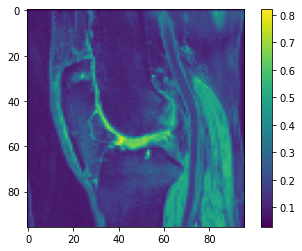

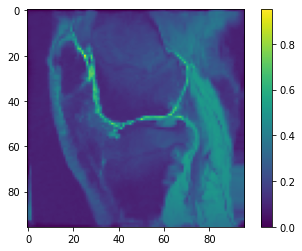

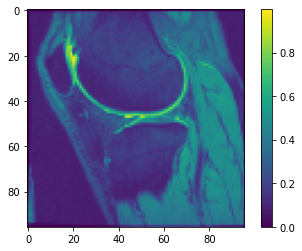

In [26]:
N +=1
plt.imshow(moving_image[N, 0, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()

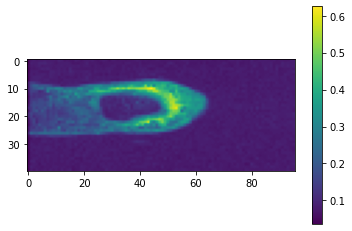

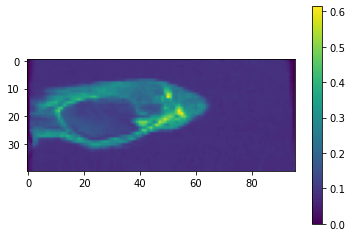

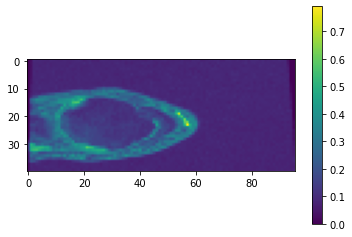

In [27]:
plt.imshow(moving_image[N, 0, :, :, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, :, :, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, :, :, 16].cpu())
plt.colorbar()

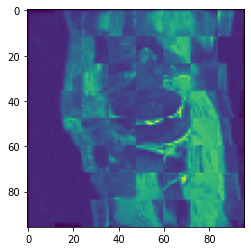

In [28]:

plt.imshow(mermaid.visualize_registration_results.checkerboard_2d(
    net.warped_fixed_image[N, 0, 8].detach().cpu(),
    moving_image[N, 0, 8].cpu()))

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>

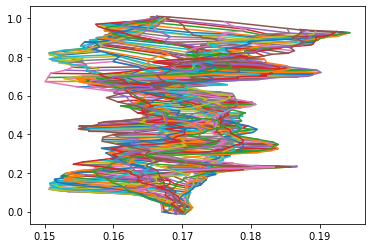

In [29]:
def grid(A, B):
    #plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[1], d[2])
    
grd(net.phi1[N, :, ::2, 16].detach().cpu())
plt.scatter

In [30]:
def get_phi(a, b):
    net(a[:BATCH_SIZE], b[:BATCH_SIZE])
    return net.phi1.detach().cpu()

In [31]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.0032115690410137177 0.017890755087137222 0.1121901273727417
0.003291669301688671 0.017890755087137222 0.10911371558904648


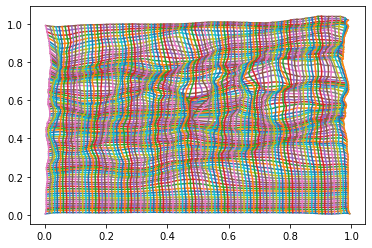

In [32]:

grd(phi2[N, :, 8, :, :])

In [33]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2 - net.identityMap.cpu(), phi1, net.spacing, 1) + phi1.cpu()

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


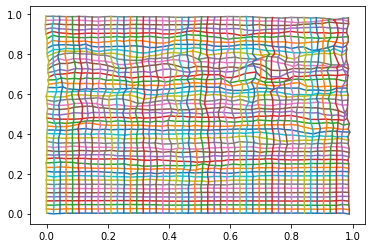

In [34]:
grd(ident_hope[N, :, 8, ::2, ::2])

In [11]:
net.cuda()

MermaidNet(
  (regis_net): UNet(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose3d(48, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(96, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): ConvTranspose3d(192, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ConvTranspose3d(512, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 

In [11]:
torch.save(net.state_dict(), "knee_aligner_chonk5")

In [9]:
net.load_state_dict(torch.load("knee_aligner_chonk4"))
optimizer.load_state_dict(torch.load("knee_aligner_optimizer4"))

In [33]:
torch.cuda.empty_cache()

In [12]:
torch.save(optimizer.state_dict(), "knee_aligner_optimizer5")

In [16]:
optimizer.state_dict()

{'state': {140058169819456: {'step': 8310,
   'exp_avg': tensor([[[[[ 1.0302e-05,  5.4854e-06,  2.0960e-06],
              [ 1.0642e-05,  4.9949e-06,  2.9960e-06],
              [ 1.3330e-05,  8.8226e-06,  3.7145e-06]],
   
             [[ 8.3299e-06,  3.8042e-06,  1.9266e-06],
              [ 6.9336e-06, -7.0312e-07, -1.3464e-06],
              [ 5.8328e-06,  2.7144e-06,  2.2695e-06]],
   
             [[ 9.9814e-06,  1.8125e-06,  8.1252e-07],
              [ 6.9429e-06,  8.6240e-07,  1.5066e-06],
              [ 6.7856e-06,  1.4800e-06,  3.1549e-06]]],
   
   
            [[[ 2.0595e-05,  2.4650e-05,  2.8910e-05],
              [ 2.1088e-05,  2.5105e-05,  3.1202e-05],
              [ 2.0257e-05,  2.5178e-05,  3.0603e-05]],
   
             [[ 2.3728e-05,  2.4855e-05,  2.7947e-05],
              [ 1.9561e-05,  2.0785e-05,  2.8101e-05],
              [ 2.3733e-05,  2.5128e-05,  3.0357e-05]],
   
             [[ 2.6175e-05,  2.9737e-05,  3.2188e-05],
              [ 2.4599e-05,  2.8308e

In [99]:
gt_net = net.regis_net
student_net = UNet().cuda()

In [100]:
optimizer = torch.optim.Adam(student_net.parameters(), lr=.0005)
student_net.train()

UNet(
  (downConvs): ModuleList(
    (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  )
  (upConvs): ModuleList(
    (0): ConvTranspose3d(24, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (2): ConvTranspose3d(64, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  )
  (lastConv): Conv3d(10, 3, kernel_size=(3, 3, 3)

In [102]:
for _ in range(100000):
    moving_image = make_batch()
    fixed_image = make_batch()
    optimizer.zero_grad()
    gt = gt_net(moving_image, fixed_image).detach()
    student_y = student_net(moving_image, fixed_image)
    
    loss = torch.mean((gt - student_y)**2)
    
    loss.backward()
    optimizer.step()
    print(loss.item())

0.001976295141503215
0.001923221512697637
0.0018711965531110764
0.0017108548199757934
0.0017292762640863657
0.0016524202656000853
0.0014262305339798331
0.0014267772203311324
0.0012905611656606197
0.0013163307448849082
0.001327947131358087
0.0011196553241461515
0.001121847191825509
0.0013010675320401788
0.0011977250687777996
0.0010736616095528007
0.0010975564364343882
0.001157520804554224
0.0010237711248919368
0.0010780931916087866
0.0011282656341791153
0.0010680751875042915
0.0010554398177191615
0.001111381221562624
0.0009719406953081489
0.0010481385979801416
0.0010155712952837348
0.0009912485256791115
0.0009843735024333
0.0009606878156773746
0.0010532913729548454
0.001002359902486205
0.0008217028225772083
0.001034704502671957
0.0009636140894144773
0.0008694304851815104
0.0008059784304350615
0.0009606214589439332
0.0008670857059769332
0.0009252111776731908
0.0008880057139322162
0.0009056610870175064
0.0008861967362463474
0.0009946809150278568
0.0008295716252177954
0.0008457547519356012

KeyboardInterrupt: 

In [97]:
optimizer.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[[-4.9498e-03, -2.6310e-03, -4.6145e-03],
                        [ 6.8784e-03,  3.0637e-02,  2.3814e-02],
                        [ 4.8928e-03,  3.1218e-02,  2.5671e-02]],
             
                       [[-3.7786e-03,  1.3380e-02,  2.0117e-02],
                        [ 2.3304e-02,  7.1484e-02,  7.2634e-02],
                        [ 2.2709e-02,  6.2157e-02,  5.7858e-02]],
             
                       [[-3.6824e-03,  2.7219e-02,  3.6578e-02],
                        [ 1.3521e-02,  5.7291e-02,  6.1605e-02],
                        [ 1.6219e-02,  2.9691e-02,  3.0826e-02]]],
             
             
                      [[[-3.7498e-03,  2.1797e-03, -3.9010e-03],
                        [-5.8452e-03, -9.5949e-03, -5.0773e-03],
                        [-4.6819e-04, -1.1328e-02, -5.3688e-03]],
             
                       [[-2.8435e-03,  4.7786e-03,  1.0557e-03],
                        [-2

In [108]:
net.regis_net =gt_net

In [135]:
next(net.parameters()).grad.size()

torch.Size([16, 2, 3, 3, 3])

In [92]:
torch.cat([random.choice(smolbrains)]).size()

torch.Size([1, 16, 32, 32])

In [24]:
medbrains[0].shape

torch.Size([1, 40, 96, 96])

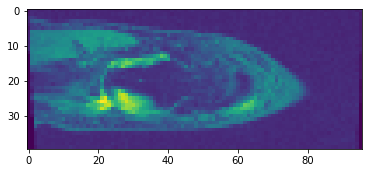

In [3]:
plt.imshow(medbrains[80][0, : , :, 20])

In [49]:
F.pad?

In [38]:
[a - b for a, b in zip(medbrains[0].size(), medbrains[1].size())]

[0, 0, 0, 0]

In [13]:
with open("/playpen/tgreer/mediumknees3" , "wb") as mk:
    pickle.dump(medbrains, mk)

In [86]:
import pickle

In [42]:
del phi1

In [43]:
del phi2

In [226]:
["RIGHT" in p for p in brain_paths][10]

True

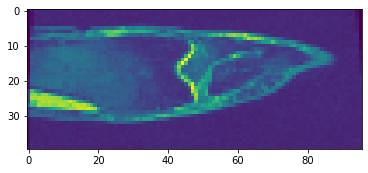

In [289]:
plt.imshow(medbrains[0][0, :, :, 32])

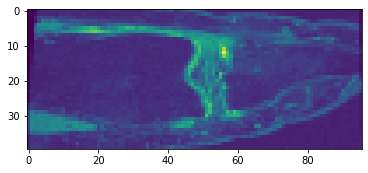

In [290]:
plt.imshow(medbrains[10][0, :, :, 32])